<b class = heading>
MIVGAN Model Generator
</b>

<style>
b.heading {
  font-size: 80px
}
</style>

**Contents**

1. Check BUNDLE
2. Check AUGMENTATION
3. Check LOSS NAME
4. Check INVARIANCE

# **Required Settings & Check**

In [1]:
# Libraries
import os, sys, csv

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.animation as anim
%matplotlib inline

import seaborn as sns

import pandas as pd

import sklearn as sk
from sklearn.model_selection import train_test_split as dataSplit

from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

import tensorflow as tf
from tensorflow import keras as K

In [2]:
import platform

print(f"Python Platform: {platform.platform()}")
print(f"Tensorflow {tf.__version__}")
#print(f"Keras {K.__version__}")
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")

gpuList = tf.config.list_physical_devices('GPU')
gpu = len(gpuList)>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")
print(gpuList)

Python Platform: Windows-10-10.0.26100-SP0
Tensorflow 2.10.0
Python 3.10.14 | packaged by Anaconda, Inc. | (main, Mar 21 2024, 16:20:14) [MSC v.1916 64 bit (AMD64)]
Pandas 2.2.1
Scikit-Learn 1.4.2
GPU is available
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Figure Display Settings
fontSize = 12; lineWidthDef = 3;
defColor = "black"; 
params = {"ytick.color" : defColor,
          "xtick.color" : defColor,
          "axes.labelcolor" : defColor,
          "axes.edgecolor" : defColor,
          "axes.titlecolor" : defColor,
          "font.size": fontSize}
plt.rcParams.update(params)
plt.rcParams['figure.figsize'] = [7, 7]
plt.rcParams['text.usetex'] = False

defaultColorSet1 = list(colors.TABLEAU_COLORS.keys())
#defaultColorSet2 = ["tomato", "forestgreen", "cornflowerblue"]

# **Simulation Data Loading**

## Bulk Data Loading (`.csv`)

Y-axis is inverted for display.

In [4]:
# Get column names
print(pd.read_csv(os.getcwd() + "/Data Folder/dataSim0/c1/data/0.csv").dtypes)

Point ID                      int64
Structured Coordinates:0      int64
Structured Coordinates:1      int64
Structured Coordinates:2      int64
density                     float64
temperature                 float64
velocity_0                  float64
velocity_1                  float64
velocity_Magnitude          float64
dtype: object


In [5]:
def simDataExtract(types, *relPath):
    
	def simDataFormat(simData, varName):

		simMapData = simData[["Structured Coordinates:0", "Structured Coordinates:1", varName]]
		simMapData = simMapData.pivot_table(index=simMapData.groupby("Structured Coordinates:0").cumcount(), 
												columns="Structured Coordinates:0", values=varName)

		simMapData = simMapData.to_numpy()                                        

		return simMapData

	# Conduction Complete Frame
	cond = 1;
	pathSimAll = []
	dataCounts = [] # Count the number of data slices in each directory
	for path in relPath:
		
		pathSim = os.getcwd() + path
		listSim = sorted([f for f in os.listdir(pathSim) if f.endswith('.csv')],
                   			key=lambda x: int(os.path.splitext(x)[0]))[cond:]
		dataCounts.append(len(listSim))
  
		for f in listSim:
			pathSimAll.append(os.path.join(pathSim, f))

	# Remove solid = +x
	dataSim = {t: np.array([simDataFormat(pd.read_csv(f), t) for f in pathSimAll])[:,:256+0,:] for t in types}
	# Turn data counts into separation indices for initial conditions
	dataSepIndex = [0]; index = 0;
	for i in range(len(dataCounts)):
		index += dataCounts[i]
		dataSepIndex.append(index)
		
	
	return dataSim, dataSepIndex

#(4,7,6,9),(4,3,6,1)
dataSimTrain, dataIndexTrain = simDataExtract(["density","temperature"],
												"/Data Folder/dataSim0/c4/data",
												"/Data Folder/dataSim0/c3/data",    
												"/Data Folder/dataSim0/c6/data",
												"/Data Folder/dataSim0/c1/data")
print(dataIndexTrain)

[0, 200, 400, 600, 800]


In [6]:
# Pressure Data Loading (X)
dataSimP = dataSimTrain["density"]

# Temperature Data Loading (Y)
dataSimT = dataSimTrain["temperature"]

In [7]:
# Constants

# Solid Thickness
solidH = 5
# Sample Display
sample = 100

In [8]:
# Jakob Number (LBM)
def Jakob(temp, cPLBM=6, hFG=0.335494, satT=0.9*0.0729):
    
    Ja = cPLBM * (temp-satT) / hFG
    
    return Ja

# Phase Boundary Quantization (With inverse Prandtl)
# Tsat = 0.9critT = 582 K ---> Pr(f,g) = (1.00, 1.68)
# Tsat = 373.15 K ---> Pr(f,g) = (1.76, 0.984)

# (With thermal conductivity)
# (528, 76.7), (680, 24.8) e-3
# (3.79551813671875, 3.839221439453125, 3.81853142578125, 3.8700667460937503)
def phaseQ(setIMG, threshold=3.79551813671875, solidVal=-1, liquid=1.0, vapor=0.0):
    
    for i in range(len(setIMG)):
        
        setIMG[i] = np.where(setIMG[i]>threshold, liquid, vapor)
        
        for row in range(solidH):
            
            # solid assignment + liquid gap
            setIMG[i][row,1:-1] = [solidVal]*(256-2)
            setIMG[i][row,0] = liquid; setIMG[i][row,-1] = liquid;
    
    return setIMG

# Value Conversion
def AtoB(field, critA, critB):
    
    field = field / critA * critB
    
    return field

# Normalization [-1,1]
def normIMG(data, wrtMax=True):
    
	if wrtMax == False:
		# To accomodate experimental minimum temperature = the saturation temperature of water
		dataMin = np.min(data)
		dataRange = np.max(data) - dataMin

		scaleFactors = [dataMin, dataRange]
		
		scaleNames = ["Mininum", "Range"]
		for i in range(len(scaleFactors)):
			print(f"{scaleNames[i]} = {scaleFactors[i]}")
	
		d01 = (data-dataMin) / dataRange

		dN = (d01 * 2) - 1
  
	else:

		dataMax = np.max(data)
		scaleFactors = [dataMax];
		print(f"Max (Modified) Jakob Number = {scaleFactors[0]}")
		dN = data / dataMax

	return dN, scaleFactors

def revertT(temp, scaleFactors, revert=True, real=True):
    
	if revert == True:
     
		# temp = (temp+1) / 2
		# temp = temp*scaleFactors[1] + scaleFactors[0]
		temp = temp*scaleFactors[0]
		
		if real == True:
			cPLBM=6; hFG=0.335494; satT=0.9*0.0729
			temp = temp*hFG / cPLBM + satT
			temp = AtoB(temp, 0.0729, 647.14)
    
	return temp

## Data Transformations

In [9]:
def rowPlot(data, titles, cmapList, centerVal, sampleIndex=50, h=4, xspace=32, yspace=64):
    
	fig, axAll = plt.subplots(1,len(data), figsize=(h*len(data), 4));
 
	if type(cmapList) == str:
		cmapList = [cmapList] * len(data)
	if centerVal == None:
		centerVal = [None] * len(data)
    
	for i in range(len(data)):
        
		if sampleIndex >= 0:
			sns.heatmap(data[i][sampleIndex], cmap=cmapList[i], 
						ax=axAll[i], center=centerVal[i], square=True,
						xticklabels=xspace, yticklabels=yspace)
		else:
			sns.heatmap(data[i], cmap=cmapList[i], 
						ax=axAll[i], center=centerVal[i], square=True,
						xticklabels=xspace, yticklabels=yspace)
   
		axAll[i].invert_yaxis();
  
		try:
			axAll[i].set_title(titles[i], fontweight='bold')
		except:
			pass

	fig.tight_layout()
	plt.show()

In [10]:
dataSimPN = dataSimP.copy()
dataSimTN = dataSimT.copy()

dataSimPN = phaseQ(dataSimPN)
dataSimTN, scaleTrain = normIMG(Jakob(dataSimTN))

Max (Modified) Jakob Number = 0.22158369449230086


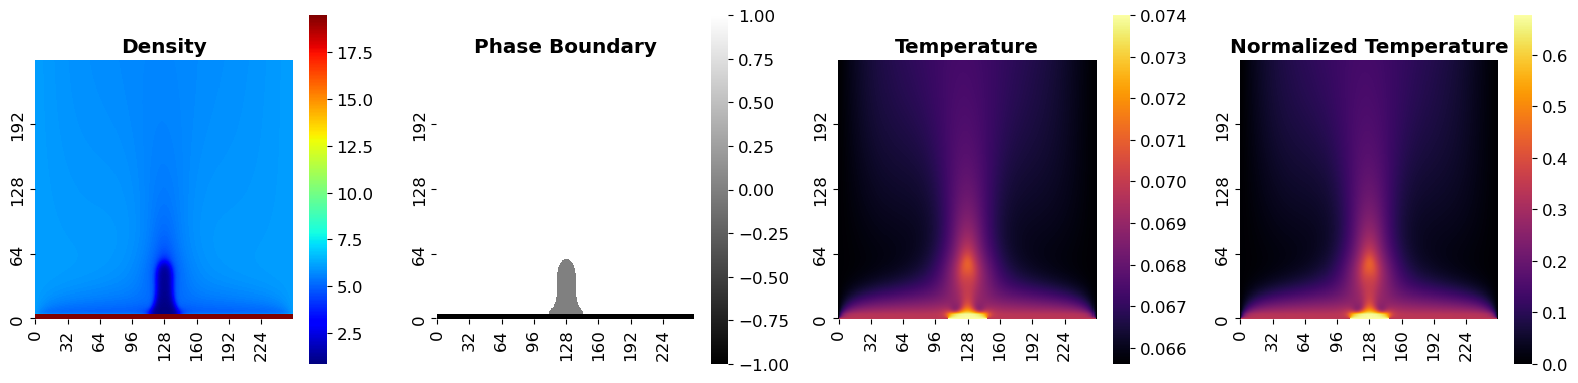

In [11]:
mainDataTitles = ['Density', 'Phase Boundary', 'Temperature', 'Normalized Temperature']
mainDataCmapList = ["jet", "binary_r", "inferno", "inferno"]
mainCenterVal = [None, None, None, None]

rowPlot([dataSimP, dataSimPN, dataSimT, dataSimTN], 
        mainDataTitles, mainDataCmapList, mainCenterVal, sampleIndex=100)

In [12]:
# Average Excess Temperature
avgExcessT = []
for i in range(len(dataIndexTrain)-1):
    
    # timeAvgT = []
    # for t in range(dataIndexTrain[i+1]-dataIndexTrain[i]):
        
    #     avgSurfaceT = np.mean(dataSimTN[t+dataIndexTrain[i],solidH-1,1:-1])
    #     timeAvgT.append(avgSurfaceT)
        
    # avgExcessT.append(np.mean(timeAvgT))
    avgExcessT.append(np.mean(dataSimTN[dataIndexTrain[i]:dataIndexTrain[i+1],solidH-1,1:-1]))
    
    
print(avgExcessT)

[0.3690734873183224, 0.4720932660959752, 0.545741762788126, 0.6997686232547203]


## Data Concatenation

# !!! Check 0

Variables with `IMG` suffix must be either a 3D image tensor in the form `(height, width, channels)` or a 4D image tensor in the form `(batch, height, width, channels)`.

In [13]:
# Input Channel Extension (for non-image files)
def channelExtend2D(dataX, dataY, prev=0, *conditions):

	height = dataX[0].shape[0] 
	width = dataX[0].shape[1]
 
	# Add desired number of previous frames
	channelCount = 1 + prev

	# Possible number of data
	batchNum = len(dataX[:])-prev
	extDataX = np.empty([batchNum, height, width, channelCount+len(conditions)])
	extDataY = np.empty([batchNum, height, width, 1])

	for i in range(batchNum):
        
		extDataX[i, :, :, 0] = dataX[i+prev]
		extDataY[i, :, :, 0] = dataY[i+prev]

		if prev > 0:
			for j in range(1,prev+1):
				
				# index i shows prediction for i+prev
				extDataX[i, :, :, j] = dataX[i+prev-j]
		
		if len(conditions) != 0:
			for j in range(len(conditions)):
				extDataX[i, :, :, prev+1+j] = conditions[j]
		
        
	return extDataX, extDataY

def channelExtendWithRef(dataX, dataY, dataSepIndex, prev=0):
    
	dataY0 = np.zeros_like(dataY[0])
	dataYRef = []
	for i in range(len(dataIndexTrain)-1):
		dataY0[:solidH, 1:-1] = avgExcessT[i]; dataYRef.append(dataY0)

	extDataX, extDataY = channelExtend2D(dataX[dataSepIndex[0]:dataSepIndex[0+1]-1], 
										dataY[dataSepIndex[0]:dataSepIndex[0+1]-1], 
										prev, dataYRef[0])

	for i in range(1,len(dataSepIndex)-1):
     
		extDataX0, extDataY0 = channelExtend2D(dataX[dataSepIndex[i]:dataSepIndex[i+1]-1], 
												dataY[dataSepIndex[i]:dataSepIndex[i+1]-1], 
												prev, dataYRef[i])
		extDataX = np.concatenate((extDataX,extDataX0),axis=0)
		extDataY = np.concatenate((extDataY,extDataY0),axis=0)
  
	return extDataX, extDataY

bundle = 3
#extDataX, extDataY = channelExtend2D(dataSimPN, dataSimTN, prev=bundle)
extDataX, extDataY = channelExtendWithRef(dataSimPN, dataSimTN, dataIndexTrain, prev=bundle) 

channelX = extDataX.shape[-1]; channelY = extDataY.shape[-1]
print(f"Number of input channels: {channelX}.\nInput Dimension: {extDataX.shape}")
print(f"Number of output channels: {channelY}.\nOutput Dimension: {extDataY.shape}")

Number of input channels: 5.
Input Dimension: (784, 256, 256, 5)
Number of output channels: 1.
Output Dimension: (784, 256, 256, 1)


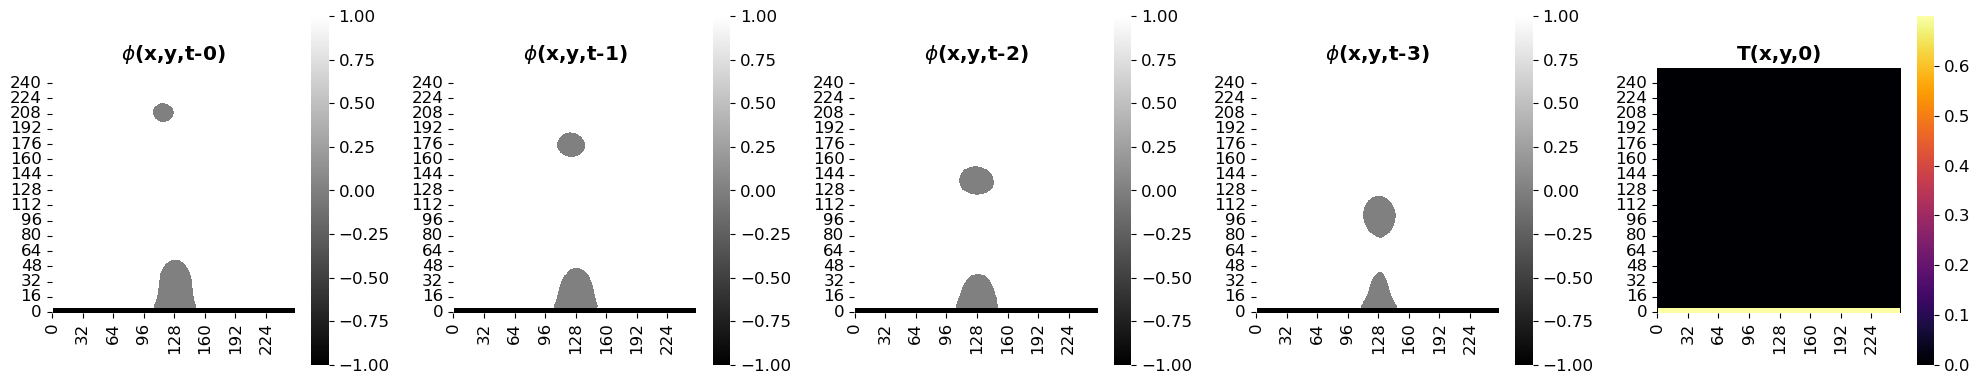

In [14]:
# Input Data Layers 
layerTitles = [f"$\phi$(x,y,t-{i})" for i in range(bundle+1)]; layerTitles.append("T(x,y,0)");
layerCmapList = ["binary_r"]*(bundle+1); layerCmapList.append("inferno")

rowPlot([extDataX[...,i] for i in range(channelX)], layerTitles, layerCmapList, None, yspace=16, sampleIndex=180)

## Data Augmentation

In [15]:
# Random Cropping of Duplicate Images
def randomShift(xIMG, yIMG, newH, newW, batch=False):

	cX = xIMG.shape[-1]; cY = yIMG.shape[-1]; 
	cT = cX + cY
	# Duplicate & Append
	stackedX = tf.concat([xIMG, xIMG], axis=1)
	stackedY = tf.concat([yIMG, yIMG], axis=1)
	stackedIMG = tf.concat([stackedX, stackedY], axis=-1)

	if batch == False:
		croppedIMG = tf.image.random_crop(stackedIMG, size=[newH, newW, cT])
	else:
		croppedIMG = tf.image.random_crop(stackedIMG, size=[xIMG.shape[0], newH, newW, cT])

	return croppedIMG[...,0:cX], croppedIMG[...,cX:]

# Data Mirroring
def randomReflect(xIMG, yIMG):

    # Random Reflection
	if tf.random.uniform(()) > 0.5:
		xIMG = tf.image.flip_left_right(xIMG)
		yIMG = tf.image.flip_left_right(yIMG)
        
	# if tf.random.uniform(()) > 0.5:
	# 	xIMG = tf.image.flip_up_down(xIMG)
	# 	yIMG = tf.image.flip_up_down(yIMG) 
    
	return xIMG, yIMG

def dataAugment(xIMG, yIMG, batch=False):
    
	#xIMG, yIMG = randomShift(xIMG, yIMG, 256, 256, batch=batch)
	xIMG, yIMG = randomReflect(xIMG, yIMG)

	return xIMG, yIMG

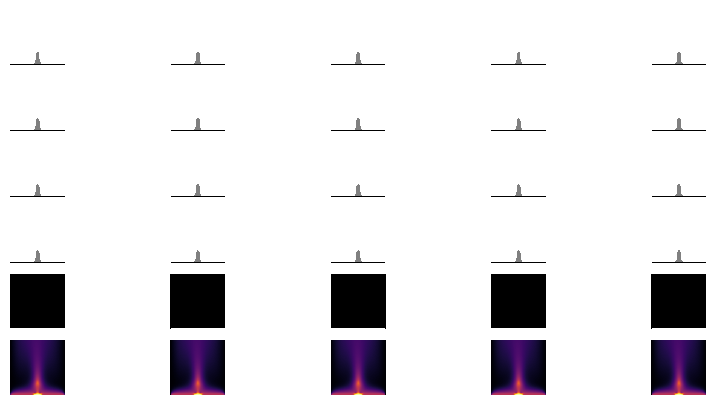

In [16]:
exampleNum = 5;
plt.figure(figsize=(2*exampleNum, exampleNum))
for i in range(exampleNum):

	augX, augY = dataAugment(extDataX[sample], extDataY[sample])
	totalChannels = channelX + channelY

	for x in range(channelX):
		
		plt.subplot(totalChannels, exampleNum, i+1+x*exampleNum)
		sns.heatmap(np.array(augX)[:,:,x], cmap="binary_r", square=True, cbar=False)
		plt.axis('off')
		plt.gca().invert_yaxis()

	for y in range(channelY):
     
		plt.subplot(totalChannels, exampleNum, i+1+(channelX+y)*exampleNum)
		sns.heatmap(np.array(augY)[:,:,y], cmap="inferno", square=True, cbar=False)
		plt.axis('off')
		plt.gca().invert_yaxis()


plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show()

del augX
del augY

## Data Pre-Processing

In [17]:
# To Tensor
def makeTensor(imageSet):
    
    #tensorSet = tf.reshape(imageSet, shape=(imageSet.shape[0], imageSet.shape[1], imageSet.shape[2], 1))
    tensorSet = tf.cast(imageSet, dtype=tf.float32)
    
    return tensorSet

# Data Cropping (Reduction)
def reduceCrop(xIMG, yIMG, xLocUL=0, yLocUL=0, finalH=256, finalW=256, crop=True):

	# xLocUL crops solid
	if crop == True:
		xCropIMG = tf.image.crop_to_bounding_box(xIMG, xLocUL, yLocUL, finalH, finalW)
		yCropIMG = tf.image.crop_to_bounding_box(yIMG, xLocUL, yLocUL, finalH, finalW)
	else:
		xCropIMG = xIMG; yCropIMG = yIMG

	return xCropIMG, yCropIMG

# Data Resizing
def resizeIMG(xIMG, yIMG, newH, newW):

    xIMG = tf.image.resize(xIMG, [newH, newW],
                              method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    yIMG = tf.image.resize(yIMG, [newH, newW],
                              method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
                               
    return xIMG, yIMG

## Train-Val Split

In [18]:
trainX, valX, trainY, valY = dataSplit(extDataX, extDataY, test_size=0.001, shuffle=False)
trainX, trainY = sk.utils.shuffle(trainX, trainY, random_state=100)
print(f"Training Data Size: {trainX.shape[0]}\nValidation Data Size: {valX.shape[0]}")

Training Data Size: 783
Validation Data Size: 1


## Data Batch

In [19]:
#%%script skip
# Clear Memory (cannot be repeated)
del dataSimP
del dataSimPN
del dataSimT
del dataSimTN

del dataSimTrain

#del extDataX
#del extDataY

In [20]:
def dataBatch(datasetX, datasetY, batchSize, train=False, augment=False):
    
	def tensorIMG(xIMG, yIMG):
		xIMG = makeTensor(xIMG); yIMG = makeTensor(yIMG); 
		return xIMG, yIMG

	#altDataAug = tf.keras.Sequential([tf.keras.layers.RandomFlip()])
    
	bufferSize = int(datasetX.shape[0]/2); print(bufferSize)
    
	datasetAll = tf.data.Dataset.from_tensor_slices((datasetX,datasetY))

	if train == True:
		datasetAll = datasetAll.map(tensorIMG)
		if augment == True:
			datasetAll = datasetAll.map(dataAugment)
		datasetAll = datasetAll.shuffle(bufferSize)
	else:
		datasetAll = datasetAll.map(tensorIMG)
  
	datasetAll = datasetAll.batch(batchSize)
 
	return datasetAll

# !!! Check 1

In [21]:
batchSize = 1
augTrainAll = dataBatch(trainX, trainY, batchSize, augment=False, train=True)
del trainX
del trainY

391


# **GAN Components**

# !!! Check 2

In [22]:
reconSCALE = 10
ganSCALE = 1
gSCALE = 1
lossRatio = f'_GANp3i1';

advLoss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
maeLoss = tf.keras.losses.MeanAbsoluteError()
mseLoss = tf.keras.losses.MeanSquaredError()

## Generators

In [23]:
def downsample(filters, size, s=2):

	initializer = tf.random_normal_initializer(0., 0.01)

	result = tf.keras.Sequential()
	result.add(
		tf.keras.layers.Conv2D(filters, size, strides=s, 
								padding='same',
								kernel_initializer=initializer,
        						use_bias=False))

	result.add(tf.keras.layers.BatchNormalization())
	result.add(tf.keras.layers.LeakyReLU())

	return result

def upsample(filters, size, applyDropout=False):
  
	initializer = tf.random_normal_initializer(0., 0.01)

	result = tf.keras.Sequential()

	result.add(tf.keras.layers.UpSampling2D(interpolation='nearest'))
	result.add(
	tf.keras.layers.Conv2D(filters, size, strides=1,
							padding='same',
							kernel_initializer=initializer,
							use_bias=False))

	result.add(tf.keras.layers.BatchNormalization())
 
	if applyDropout:
		result.add(tf.keras.layers.Dropout(0.5))

	result.add(tf.keras.layers.LeakyReLU())

	return result

In [24]:
def Generator(shapeDim1, shapeDim2, channelCountX, channelCountY):

	inputs = tf.keras.layers.Input(shape=[shapeDim1, shapeDim2, channelCountX])

	encoder = [
		downsample(16, 5),  
		downsample(32, 5), 
		downsample(64, 5),  
		downsample(128, 5),  
		downsample(256, 5),  
		downsample(512, 5),  
		#downsample(512, 5), 
		#downsample(512, 5)
	]

	decoder = [
		#upsample(512, 5),
		#upsample(512, 5),  
		upsample(256, 5),  
		upsample(128, 5),  
		upsample(64, 5),  
		upsample(32, 5),  
		upsample(16, 5)
	]

	#initializer = tf.random_normal_initializer(0., 0.02)
	initializer = tf.keras.initializers.HeNormal()
	penult = upsample(8, 5) 
	# last = tf.keras.layers.Conv2DTranspose(channelCountY, 4,
	# 										strides=2,
	# 										padding='same',
	# 										kernel_initializer=initializer,
	# 										activation='tanh') 

	last = tf.keras.layers.Conv2D(channelCountY, 5,
									strides=1,
									padding='same',
									kernel_initializer=initializer,
									activation='tanh')


	x = inputs
	#x = tf.keras.layers.RandomFlip()(x)

	# Downsampling (Encoder)
	skips = []
	for extractLayer in encoder:
		x = extractLayer(x)
		skips.append(x)

	skips = reversed(skips[:-1])

	# Upsampling & Skip Connections (Decoder)
	for expandLayer, skip in zip(decoder, skips):
		x = expandLayer(x)
		x = tf.keras.layers.Concatenate()([x, skip])

	x = penult(x)
	x = last(x)

	return tf.keras.Model(inputs=inputs, outputs=x), len(decoder)

In [25]:
generator, skipCount = Generator(extDataX.shape[1], extDataY.shape[2], channelX, channelY)
print(f"Number of Skip Connections = {skipCount}")
generator.summary(line_length=120)
#tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Number of Skip Connections = 5
Model: "model"
________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            
 input_1 (InputLayer)                  [(None, 256, 256, 5)]      0             []                                      
                                                                                                                        
 sequential (Sequential)               (None, 128, 128, 16)       2064          ['input_1[0][0]']                       
                                                                                                                        
 sequential_1 (Sequential)             (None, 64, 64, 32)         12928         ['sequential[0][0]']                    
                                                                                                           

## Generator Loss Function

In [26]:
def lossG(discReal, discGen, genIMG, targetIMG, inputIMG):

	# GAN Loss
	lossGAN = advLoss(tf.ones_like(discGen), discGen)

	# Reconstruction Loss
	lossREC = mseLoss(targetIMG, genIMG) 
 
	# Boundary Condition Loss
	#lossBC = mseLoss(targetIMG[:,0,:,:],genIMG[:,0,:,:])
 
	# Gradient Loss
	trueDY, trueDX = tf.image.image_gradients(targetIMG)
	predDY, predDX = tf.image.image_gradients(genIMG)
	lossG = mseLoss(trueDY, predDY) + mseLoss(trueDX, predDX)
	
	totalLossG = (ganSCALE * lossGAN) + (reconSCALE * lossREC) + (gSCALE * lossG)
     
	lossComponentsG = [totalLossG, lossGAN, lossREC]

	return lossComponentsG

## Discriminator

In [27]:
def downsampleD(filters, size, s=1):

	initializer = tf.random_normal_initializer(0., 0.1)

	result = tf.keras.Sequential()
	result.add(
		tf.keras.layers.Conv2D(filters, size, strides=s, 
								padding='valid',
								kernel_initializer=initializer,
        						use_bias=False))

	result.add(tf.keras.layers.BatchNormalization())
	result.add(tf.keras.layers.LeakyReLU())

	return result

In [28]:
def Discriminator(shapeDim1, shapeDim2, channelCountX, channelCountY):

	# Patch size = receptive field size + (kernel size-1)*stride
	# Stride = stride*2
	patchSize = 1; strideStack = 1;

	#initializer = tf.random_normal_initializer(0., 0.02)
	#initializer = tf.keras.initializers.GlorotNormal()

	inp = tf.keras.layers.Input(shape=[shapeDim1, shapeDim2, channelCountX], name='inputIMG')
	tar = tf.keras.layers.Input(shape=[shapeDim1, shapeDim2, channelCountY], name='targetIMG')

	x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, ...,  channels*2)

	# down1A = downsample(2, 5, s=1)(inp); patchSize += (5-1)*strideStack; strideStack *= 1;
	# down1B = downsample(2, 5, s=1)(tar); #patchSize += (4-1)*strideStack; strideStack *= 2;
	# down1 = tf.keras.layers.concatenate([down1A, down1B])
 
	# down2 = downsample(4, 5)(down1); patchSize += (5-1)*strideStack; strideStack *= 2;
 
	# down3 = downsample(4, 5, s=2)(x)
	# down4 = tf.keras.layers.concatenate([down2, down3])
 
	# down0 = downsample(8, 7)(down4); patchSize += (7-1)*strideStack; strideStack *= 2;

	down1 = downsample(16, 7)(x); patchSize += (7-1)*strideStack; strideStack *= 2;
	down2 = downsample(32, 5)(down1); patchSize += (5-1)*strideStack; strideStack *= 2;
	down3 = downsample(64, 3)(down2); patchSize += (3-1)*strideStack; strideStack *= 2;
	# down4 = downsample(128, 4)(down3); patchSize += (4-1)*strideStack; strideStack *= 2;
	# down5 = downsample(256, 4)(down4); patchSize += (4-1)*strideStack; strideStack *= 2;

	# endLayerCount = 256;
	# zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  
	# conv = tf.keras.layers.Conv2D(endLayerCount*2, 4, strides=1,
	# 							kernel_initializer=initializer,
	# 							use_bias=False)(down3)
	# patchSize += (4-1)*strideStack; strideStack *= 1;

	# batchnorm1 = tf.keras.layers.LayerNormalization()(conv)
	# leaky_relu = tf.keras.layers.LeakyReLU()(conv)

	# zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  
	# last = tf.keras.layers.Conv2D(1, 4, strides=2,
	# 								kernel_initializer=initializer)(down0)
	#penult = downsample(1,4)(down0); patchSize += (4-1)*strideStack; strideStack *= 2;
	last = tf.keras.layers.Conv2D(1, 5, strides=1,
	 								kernel_initializer='he_normal')(down3)
	patchSize += (5-1)*strideStack; strideStack *= 1

	return tf.keras.Model(inputs=[inp, tar], outputs=last), patchSize, last.get_shape().as_list()

In [29]:
discriminator, patchSize, lastLayer = Discriminator(extDataX.shape[1], extDataY.shape[2], channelX, channelY)
dShapeDim1 = lastLayer[1]; dShapeDim2 = lastLayer[2]
print(f"Receptive Field Size = {patchSize}")
print(f"Discriminator Output Dimension = ({dShapeDim1},{dShapeDim2})")
discriminator.summary(line_length=120)
#tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

Receptive Field Size = 55
Discriminator Output Dimension = (28,28)
Model: "model_1"
________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            
 inputIMG (InputLayer)                 [(None, 256, 256, 5)]      0             []                                      
                                                                                                                        
 targetIMG (InputLayer)                [(None, 256, 256, 1)]      0             []                                      
                                                                                                                        
 concatenate_5 (Concatenate)           (None, 256, 256, 6)        0             ['inputIMG[0][0]',                      
                                                                     

## Discriminator Loss Function

In [30]:
def lossD(discReal, discGen, inputIMG, genIMG, targetIMG, modelD):

	# Real Check
	lossReal = advLoss(tf.ones_like(discReal), discReal)

	# Fake Check
	lossFake = advLoss(tf.zeros_like(discGen), discGen)

	totalLossD = lossReal + ganSCALE * lossFake 
 
	lossComponentsD = [totalLossD, lossReal, lossFake]

	return lossComponentsD

## Result Output

In [31]:
def resultSetIMG(modelG, modelD, input, target, layer=0, tickCount=3, invertAxes=True, hideAxes=True):
    
	subtitles = ['Input', 'Target', 'Output', 'Error', 'Real Eval', 'Fake Eval']
	cmapList = ['binary_r', 'inferno', 'inferno', 'seismic', 'coolwarm', 'coolwarm']
	centerValue = [None, None, None, 0, 0, 0]
	cbarShow = [True, True, True, True, True, True]
 
	baseSize = 6; figH = 2;
	fig, axes = plt.subplots(1,len(subtitles),figsize=(figH*baseSize, figH))
 
    # Evaluate image
	predTensor = modelG(input[tf.newaxis, ...], training=True)
	pred = np.array(predTensor)[0]
	error = pred[:,:,layer] - target[:,:,layer]
 
	discOutFake = modelD([input[tf.newaxis, ...], predTensor], training=False)
	discOutReal = modelD([input[tf.newaxis, ...], tf.expand_dims(target, 0)], training=False)

	# Display range
	genMin = np.min(target[:,:,layer])
	genMax = np.max(target[:,:,layer])
	discMin = np.min(np.minimum(discOutFake[0,:,:,layer], discOutReal[0,:,:,layer]))
	discMax = np.max(np.maximum(discOutFake[0,:,:,layer], discOutReal[0,:,:,layer]))

	cbarMin = [None, genMin, genMin, None, discMin, discMin]
	cbarMax = [None, genMax, genMax, None, discMax, discMax]
 
	figures = [input[:,:,layer], target[:,:,layer], pred[:,:,layer], error, 
            discOutReal[0,:,:,layer], discOutFake[0,:,:,layer]]

	for i in range(len(figures)):
        
		# Plot already normalized.
		sns.heatmap(figures[i], cmap=cmapList[i], cbar=cbarShow[i],
              		center=centerValue[i], vmin=cbarMin[i], vmax=cbarMax[i],
					square=True, ax=axes[i],
     				xticklabels=int(figures[i].shape[1]/tickCount), yticklabels=int(figures[i].shape[0]/tickCount))
		
		axes[i].set_title(subtitles[i], fontweight='bold')
  
		if invertAxes == True:
			axes[i].invert_yaxis()
			
		if hideAxes == True:          
			axes[i].axis('off')

	fig.tight_layout()
	plt.show()

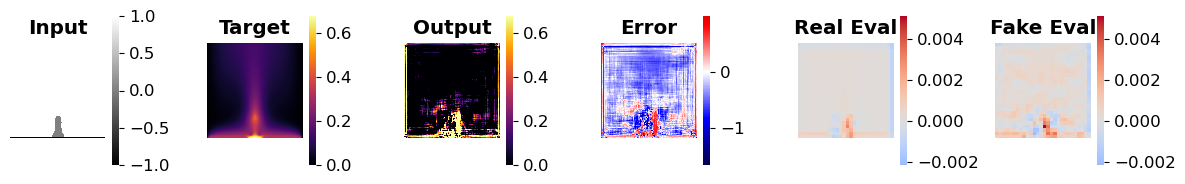

In [32]:
resultSetIMG(generator, discriminator, extDataX[sample], extDataY[sample], layer=0)

# **GAN Architecture**

## Optimizer

In [33]:
optimizerG = tf.keras.optimizers.Adam(learning_rate=1e-4)
optimizerD = tf.keras.optimizers.Adam(learning_rate=1e-4)

## Training Step Definition

In [34]:
def lossCompute0(inputIMG, targetIMG, trainState=True):

	# No Inversion
	fakeIMG = generator(inputIMG, training=trainState)

	discReal = discriminator([inputIMG, targetIMG], training=trainState)
	discGen = discriminator([inputIMG, fakeIMG], training=trainState)

	cLossG = lossG(discReal, discGen, fakeIMG, targetIMG, inputIMG)
	cLossD = lossD(discReal, discGen, inputIMG, fakeIMG, targetIMG, discriminator)
 
	cLossD.append(cLossG[1])
    
	return cLossG, cLossD

# !!! Check 3

In [35]:
def lossCompute(inputIMG, targetIMG, trainState=True):
 
	# No inversion
	cLossG, cLossD = lossCompute0(inputIMG, targetIMG, trainState=trainState) 
 
	# LR Inversion
	# invI1 = tf.image.flip_left_right(inputIMG)
	# invReal1 = tf.image.flip_left_right(targetIMG)
	# cLossG0, cLossD0 = lossCompute0(invI1, invReal1, trainState=trainState)
	# cLossG = [sum(x)/2 for x in zip(cLossG, cLossG0)]
	# cLossD = [sum(x)/2 for x in zip(cLossD, cLossD0)]
 
	# # UD Inversion
	# invI2 = tf.image.flip_up_down(inputIMG)
	# invReal2 = tf.image.flip_up_down(targetIMG)
	# cLossG0, cLossD0 = lossCompute0(invI2, invReal2, trainState=trainState)
	# cLossG = [sum(x) for x in zip(cLossG, cLossG0)]
	# cLossD = [sum(x) for x in zip(cLossD, cLossD0)]
 
	# B Inversion
	# invB = tf.image.flip_up_down(invI1)
	# invRealB = tf.image.flip_up_down(invReal1)
	# cLossG0, cLossD0 = lossCompute0(invB, invRealB, trainState=True)
	# cLossG = [sum(x) for x in zip(cLossG, cLossG0)]
	# cLossD = [sum(x) for x in zip(cLossD, cLossD0)]
    
	return cLossG, cLossD

In [36]:
@tf.function
def trainStep(inputIMG, targetIMG):

	trainRepeat = [2,1]; #[G,D]
	#totalLossG, lossGAN, lossREC, totalLossD, lossREAL, lossFAKE = lossCompute(inputIMG, targetIMG)
   
	for i in range(trainRepeat[0]):
   
		with tf.GradientTape() as genGrad:
			stepLossG, stepLossD = lossCompute(inputIMG, targetIMG)
		gGrad = genGrad.gradient(stepLossG[0], generator.trainable_variables)
		optimizerG.apply_gradients(zip(gGrad, generator.trainable_variables))
  
	for i in range(trainRepeat[1]):
		
		with tf.GradientTape() as discGrad:
			stepLossG, stepLossD = lossCompute(inputIMG, targetIMG)
		dGrad = discGrad.gradient(stepLossD[0], discriminator.trainable_variables)
		optimizerD.apply_gradients(zip(dGrad, discriminator.trainable_variables))
  
	#stepLossG, stepLossD = lossCompute(inputIMG, targetIMG)

	#return stepLossG, stepLossD

In [37]:
# Initialize All Losses
allLossG = []; allLossD = []
allLossGV = []; allLossDV = []
netSteps = 0;

In [38]:
def fitStep(trainDatasetX, trainDatasetY, 
            valDatasetX, valDatasetY, 
            steps, epochs, trainDatasetAll,
            allLossG, allLossD, allLossGV, allLossDV):

	# Stepwise Display
	trainIndex = 10; valIndex = 0; 
	figCount = epochs; dotCount = 30; 
	displayFrequency = int(steps/figCount);
	progressFrequency = int(steps/(figCount*dotCount));

	for step, (trainIMGX, trainIMGY) in trainDatasetAll.repeat().take(steps).enumerate():

		step = np.array(step)
  
		trainStep(trainIMGX, trainIMGY)
		cLossG, cLossD = lossCompute(trainIMGX, trainIMGY)
		cLossGV, cLossDV = lossCompute(makeTensor(valDatasetX), makeTensor(valDatasetY))
  
		allLossG.append(np.array(cLossG).tolist())
		allLossD.append(np.array(cLossD).tolist())
		allLossGV.append(np.array(cLossGV).tolist())
		allLossDV.append(np.array(cLossDV).tolist())

		if (step+1) % displayFrequency == 0:
			print('\nStep', step+1, 'Result')
			resultSetIMG(generator, discriminator, trainDatasetX[trainIndex], trainDatasetY[trainIndex])
			resultSetIMG(generator, discriminator, valDatasetX[valIndex], valDatasetY[valIndex])

		if step % progressFrequency == 0:
			print('.', end='', flush=True)

	#return allLossG, allLossD, allLossGV, allLossDV

## Model Training

In [39]:
import gc
tf.config.experimental.get_memory_info('GPU:0')['current']/1024/1024/1024

2.330737352371216

# !!! Check 4

...............................
Step 783 Result


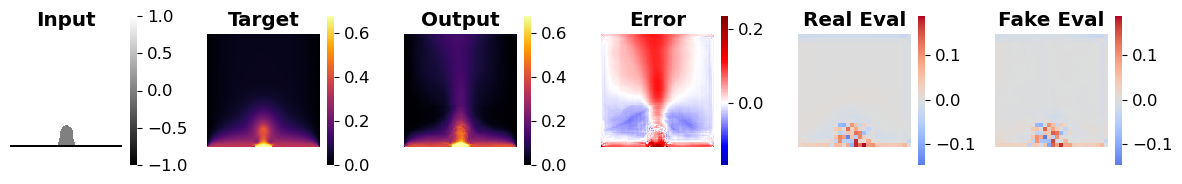

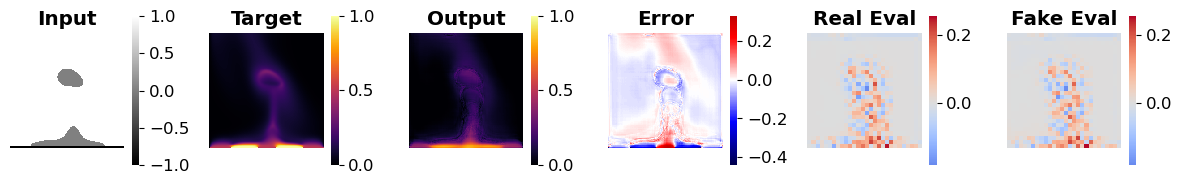

..............................
Step 1566 Result


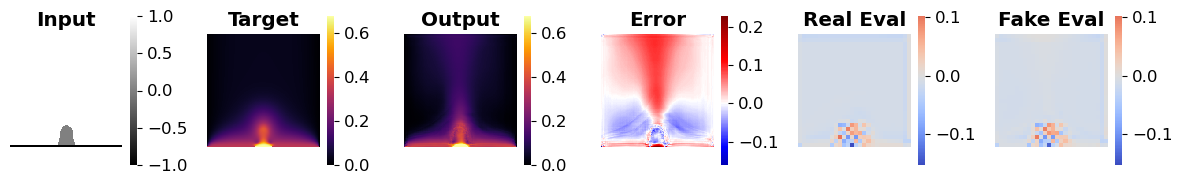

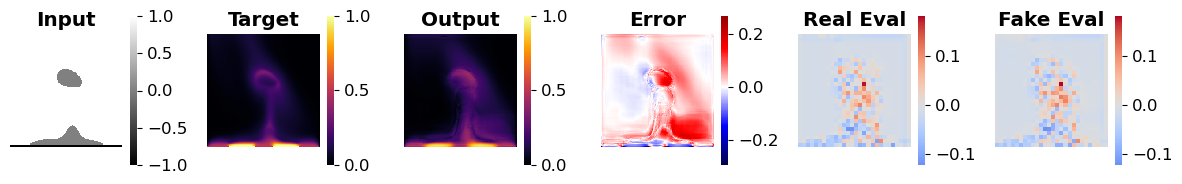

..............................
Step 2349 Result


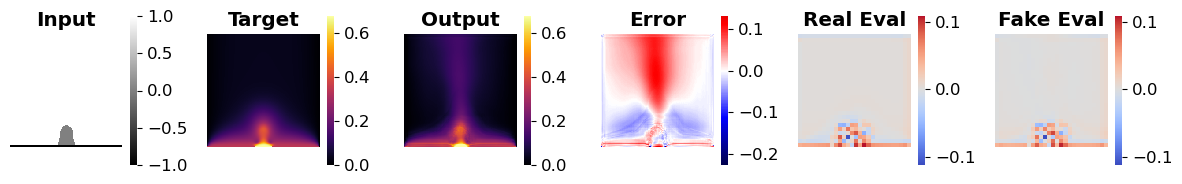

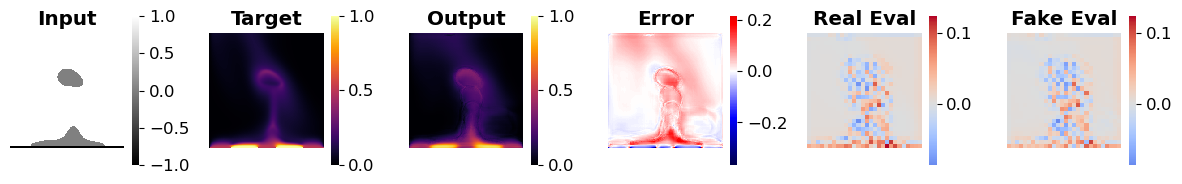

..............................
Step 3132 Result


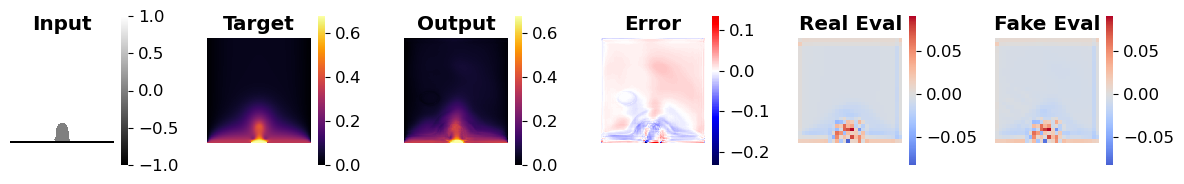

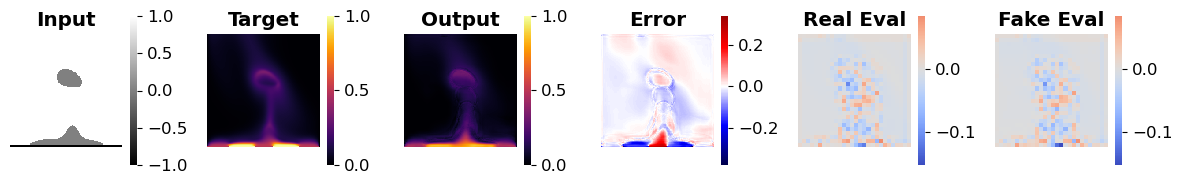

..............................
Step 3915 Result


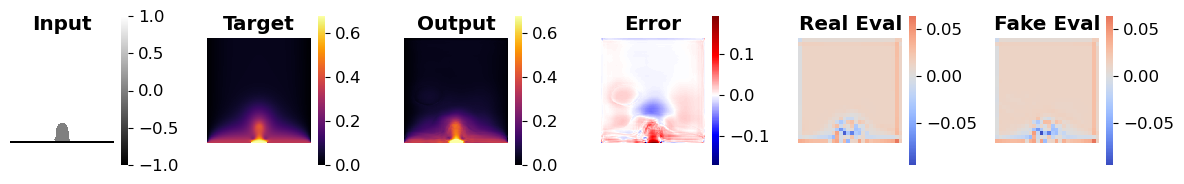

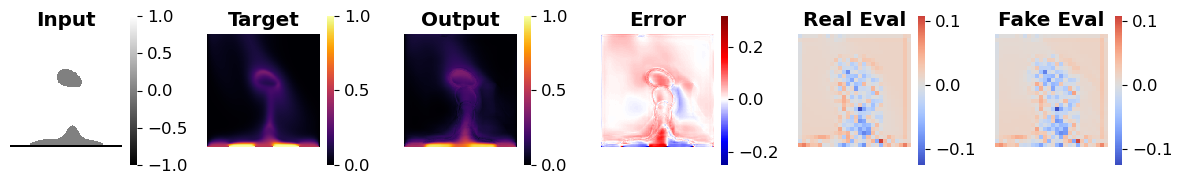

..............................
Step 4698 Result


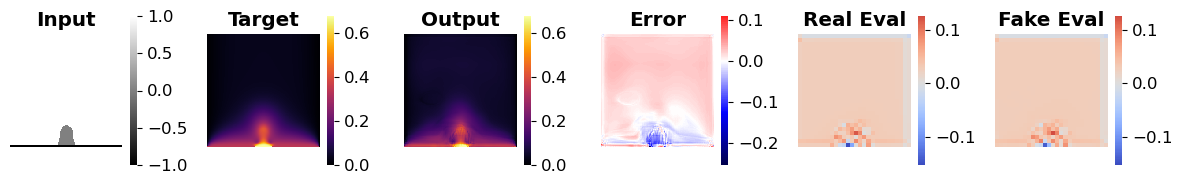

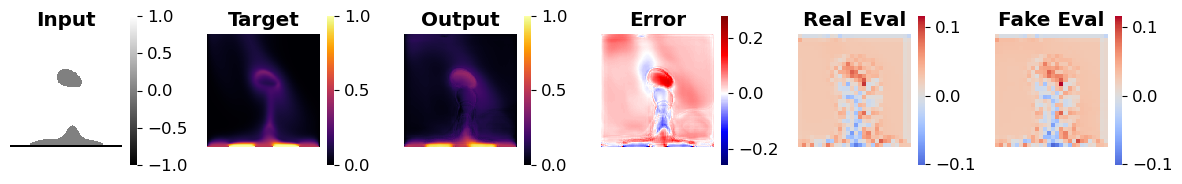

..............................
Step 5481 Result


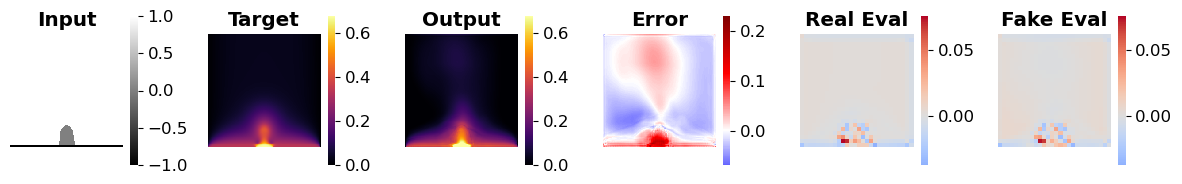

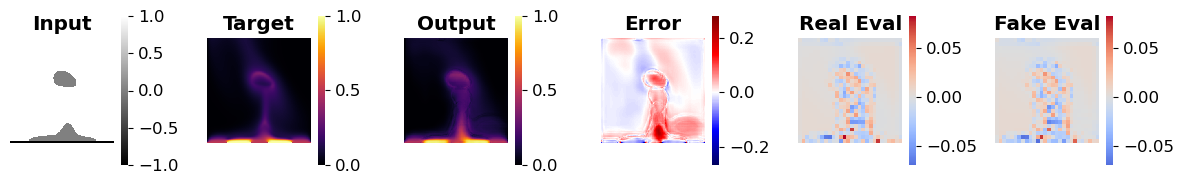

..............................
Step 6264 Result


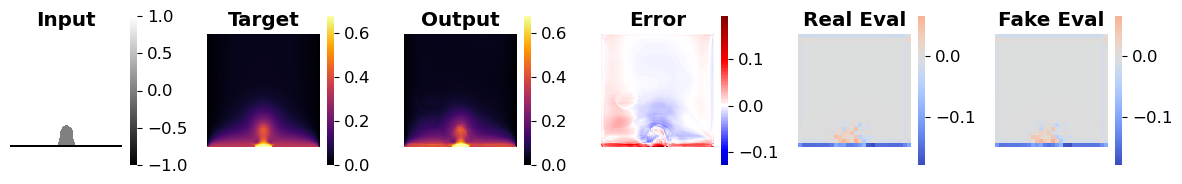

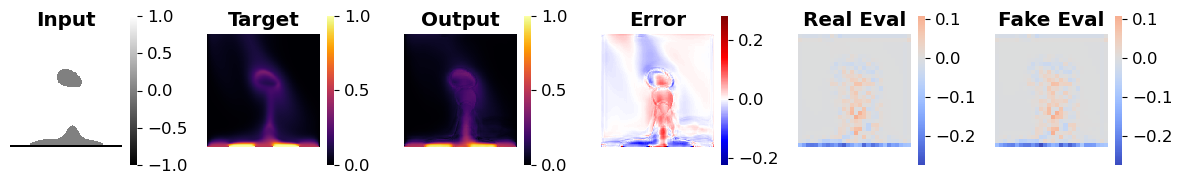

..............................
Step 7047 Result


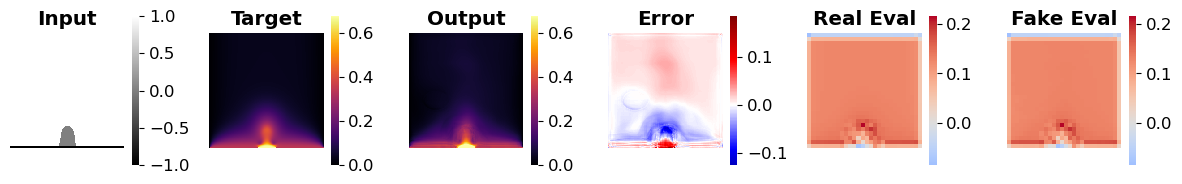

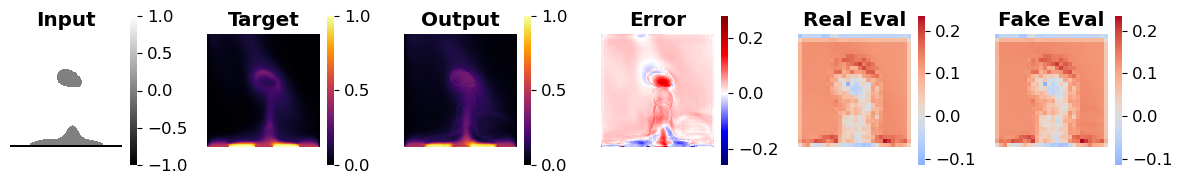

...............................
Step 7830 Result


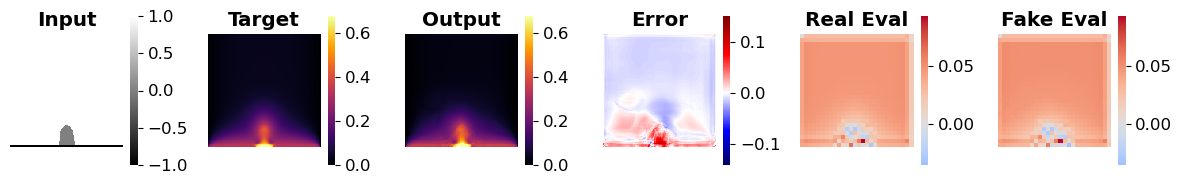

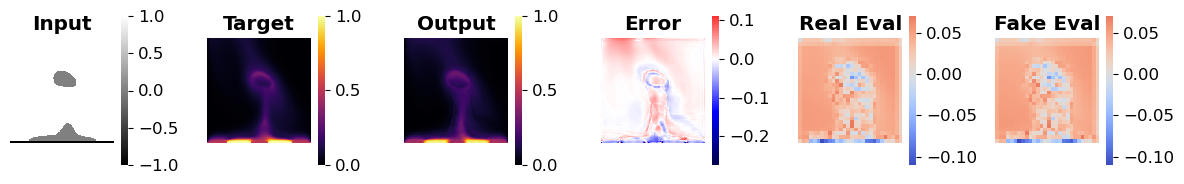

..............................
Step 8613 Result


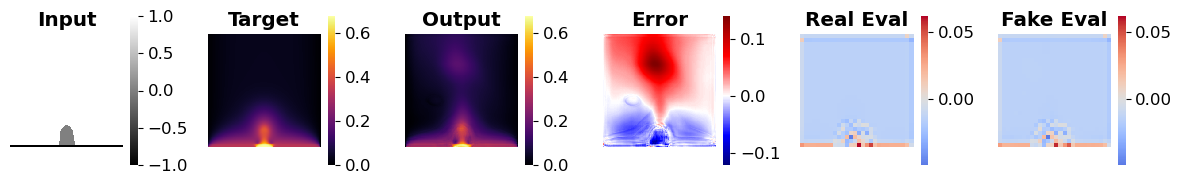

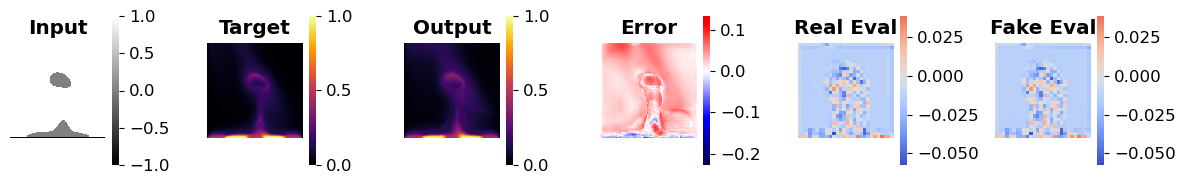

..............................
Step 9396 Result


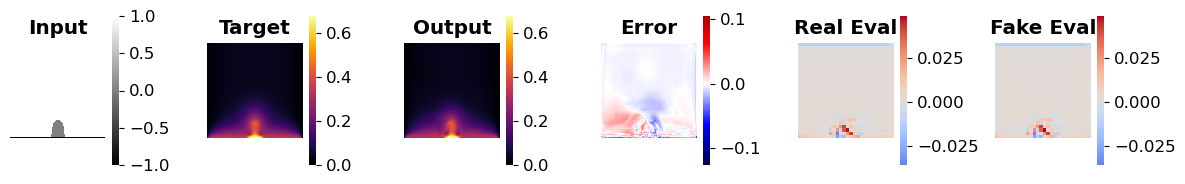

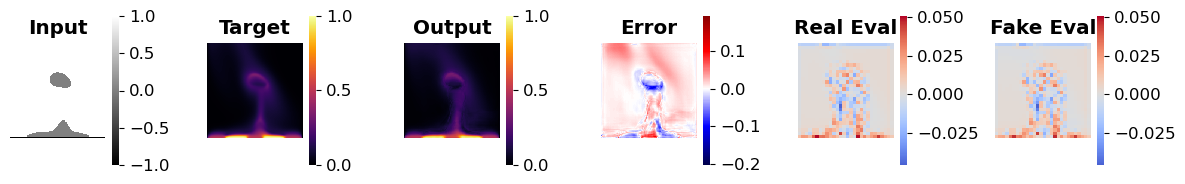

..............................
Step 10179 Result


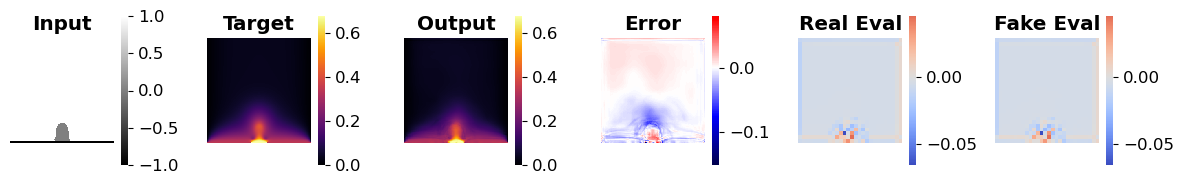

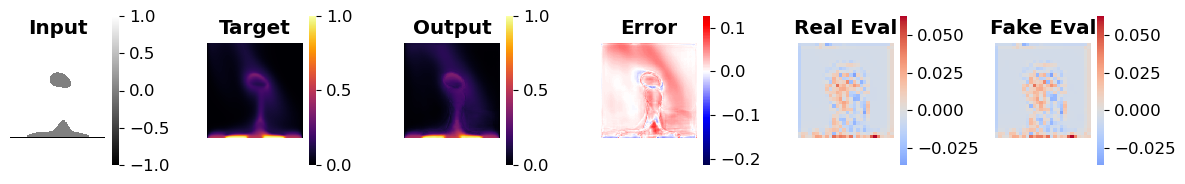

..............................
Step 10962 Result


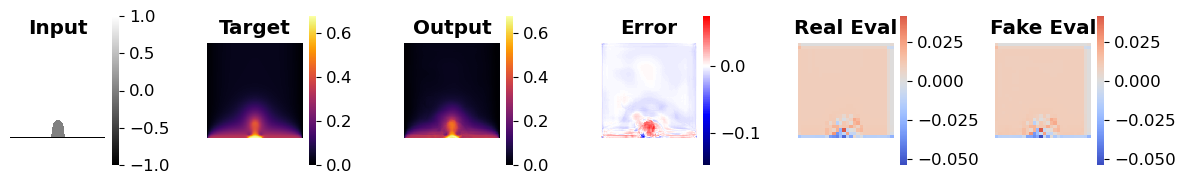

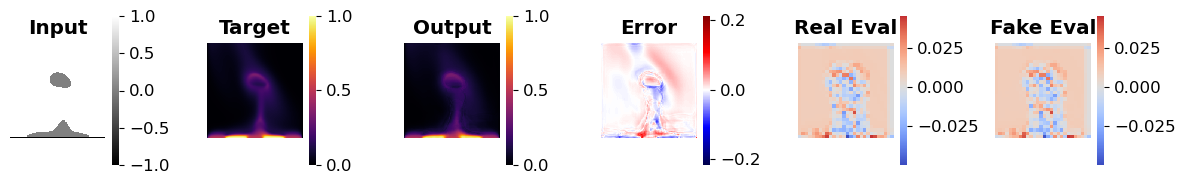

..............................
Step 11745 Result


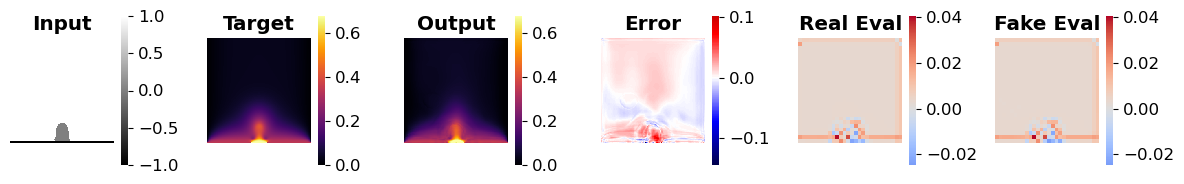

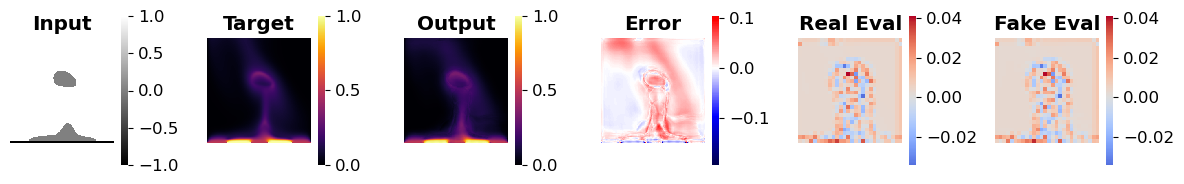

..............................
Step 12528 Result


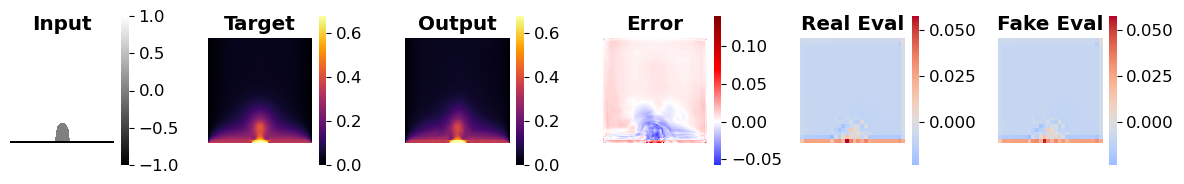

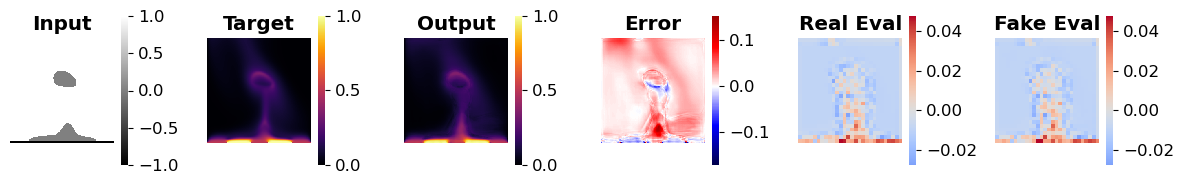

..............................
Step 13311 Result


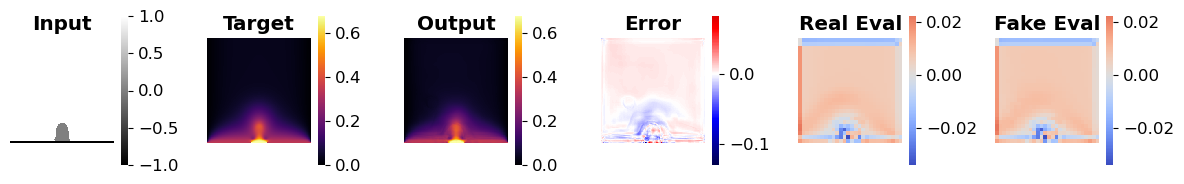

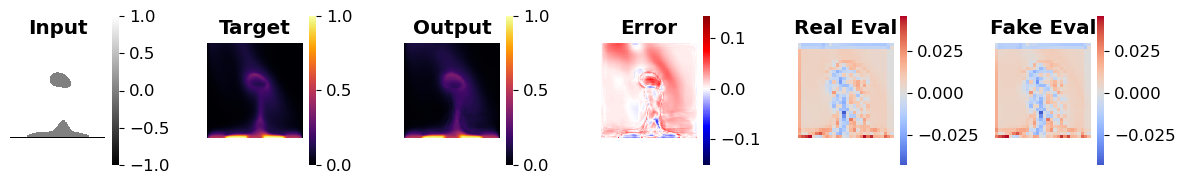

...............................
Step 14094 Result


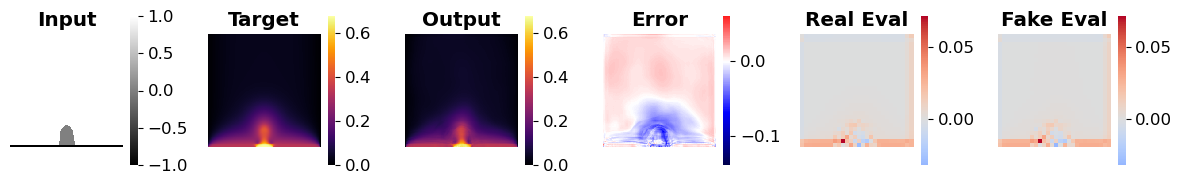

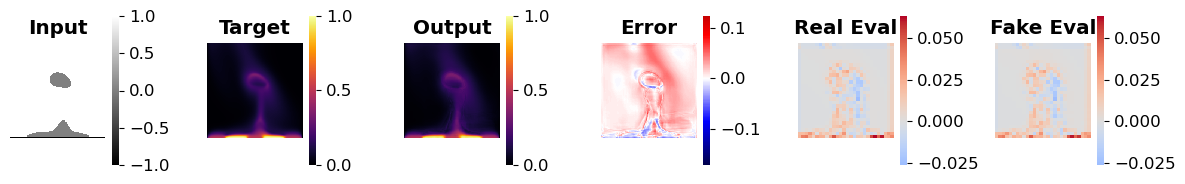

..............................
Step 14877 Result


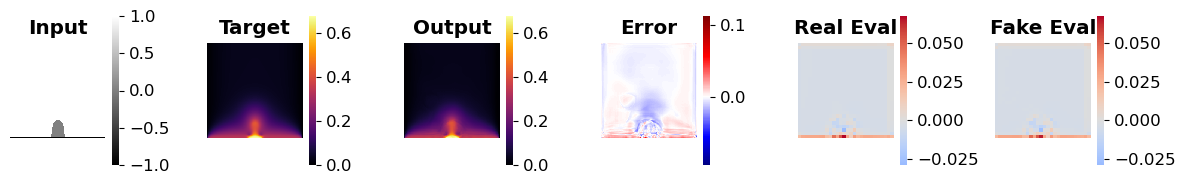

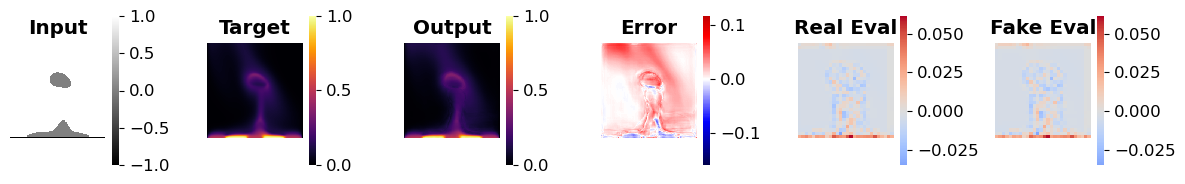

..............................
Step 15660 Result


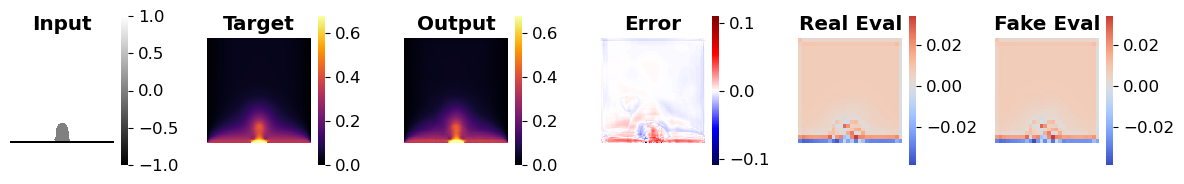

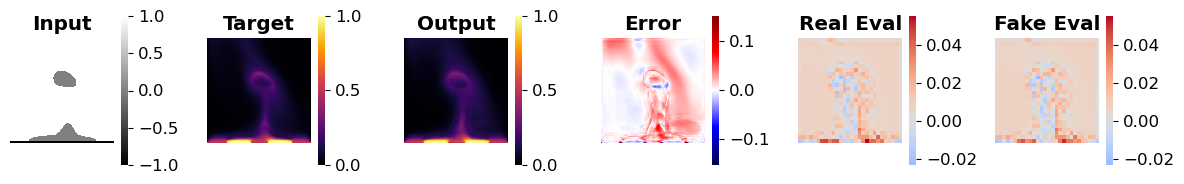

..............................
Step 16443 Result


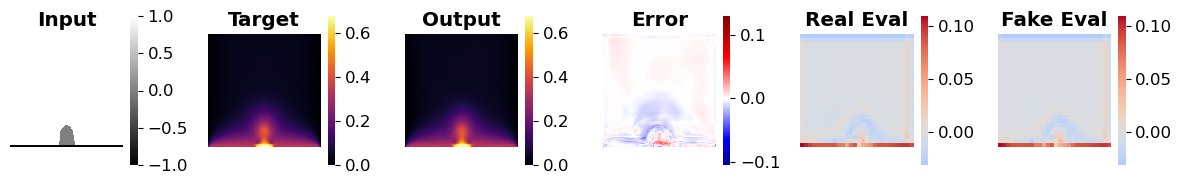

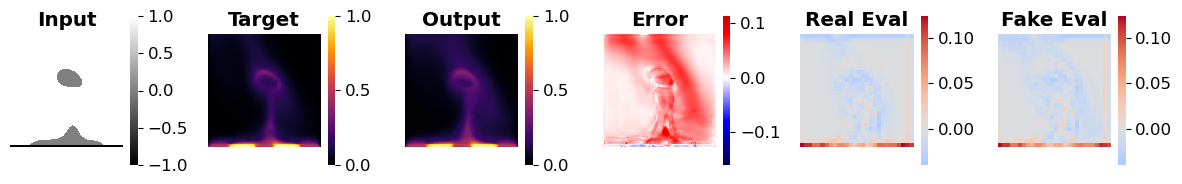

..............................
Step 17226 Result


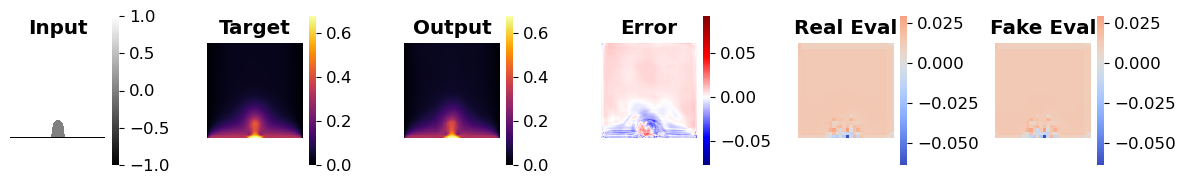

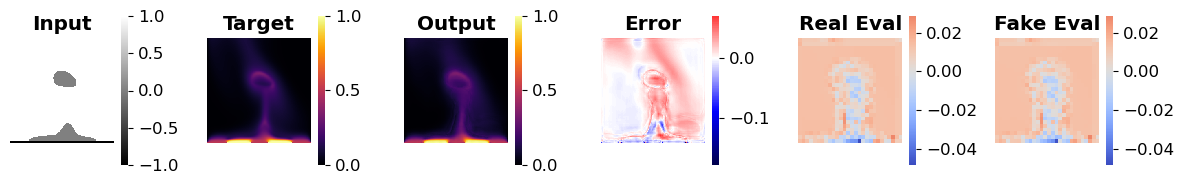

..............................
Step 18009 Result


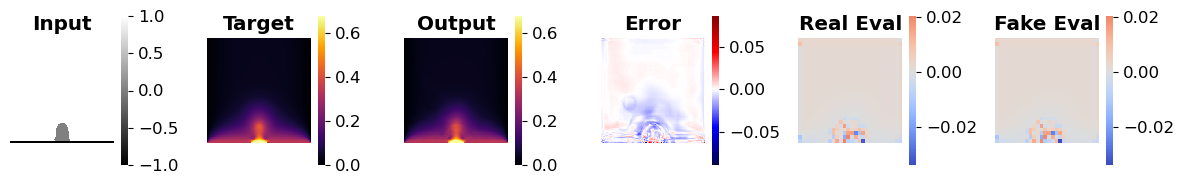

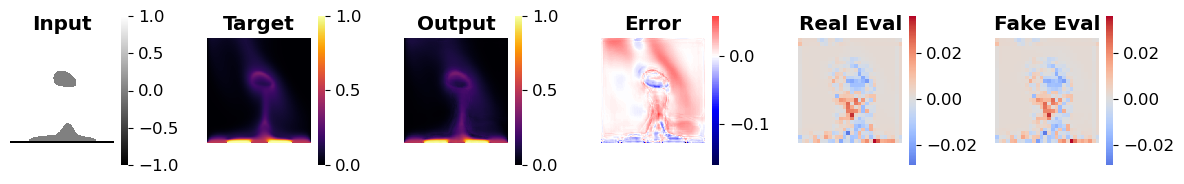

..............................
Step 18792 Result


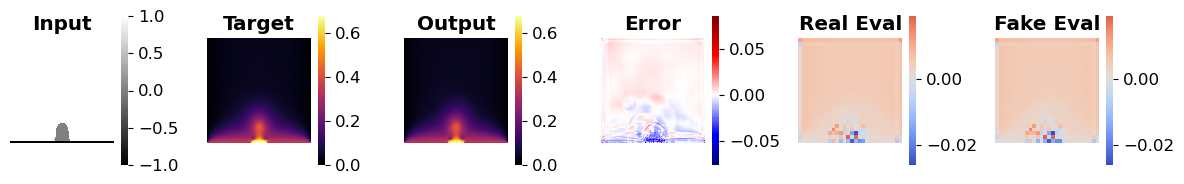

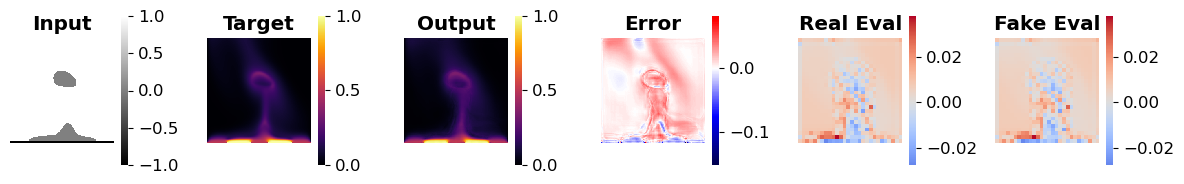

..............................
Step 19575 Result


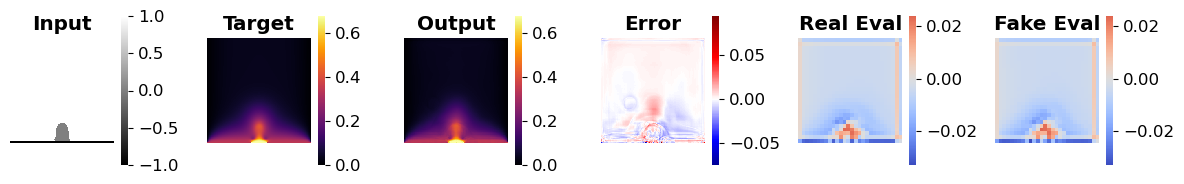

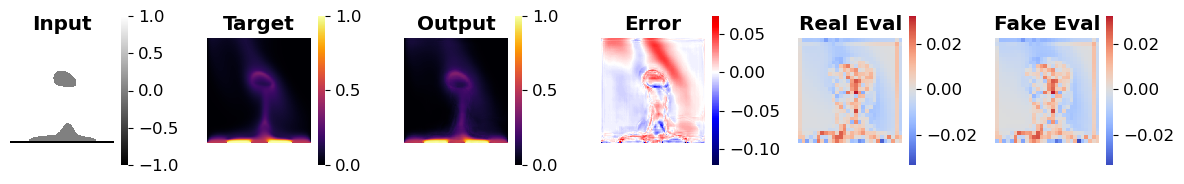

..............................
Step 20358 Result


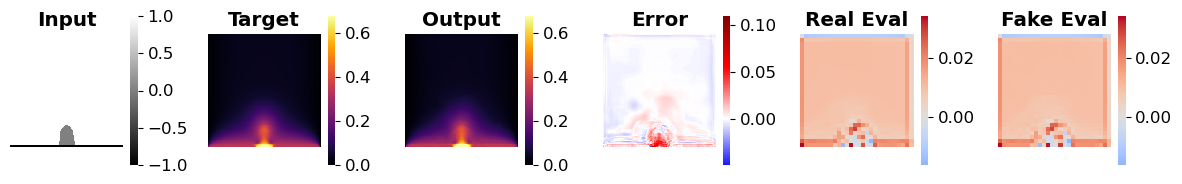

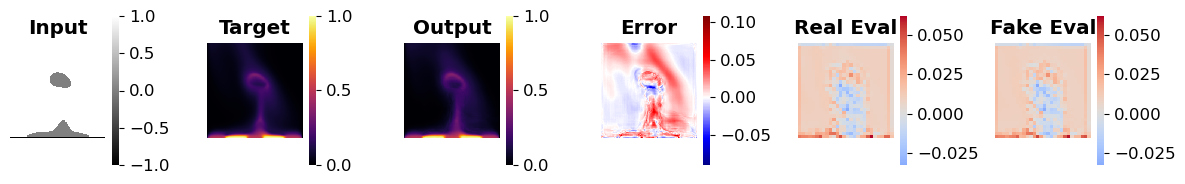

...............................
Step 21141 Result


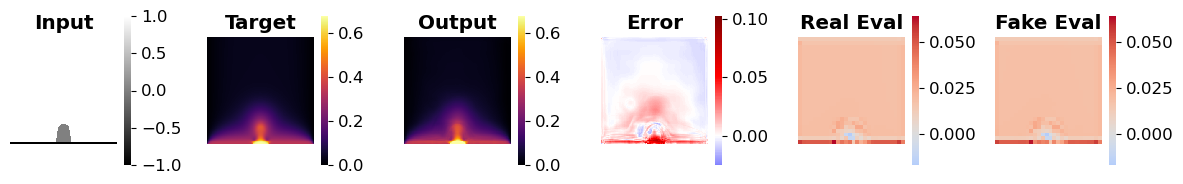

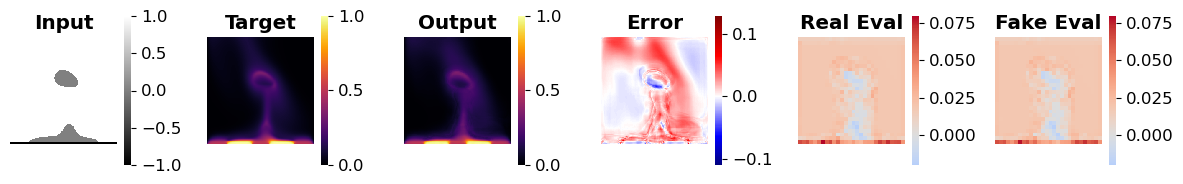

..............................
Step 21924 Result


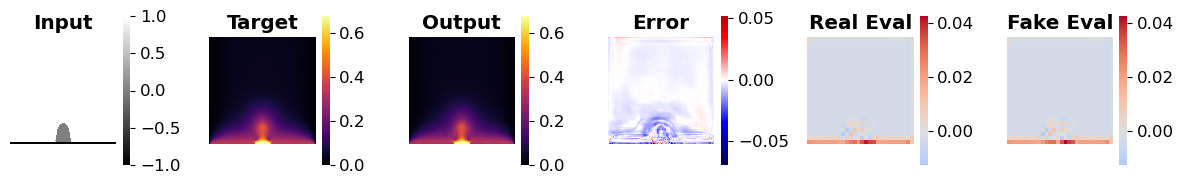

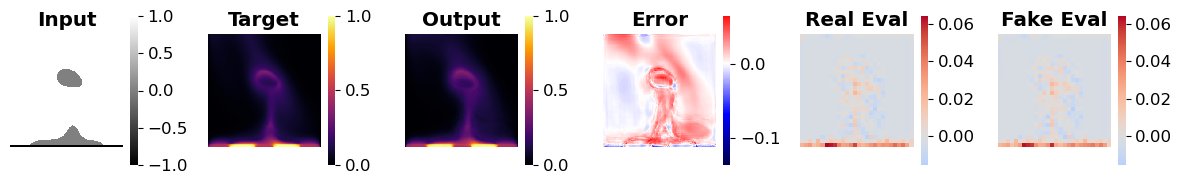

..............................
Step 22707 Result


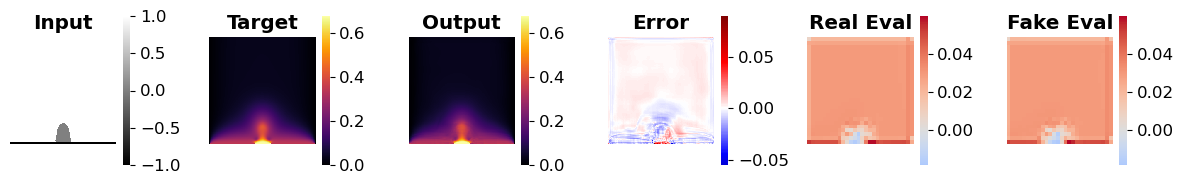

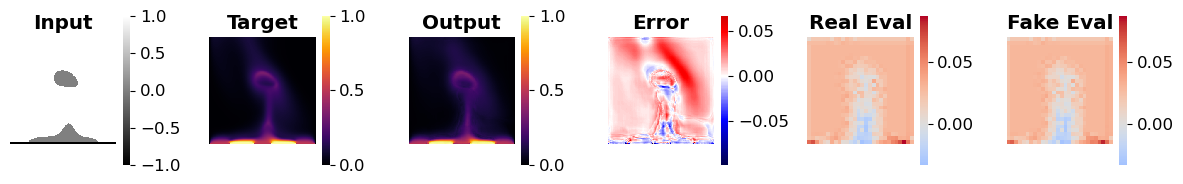

..............................
Step 23490 Result


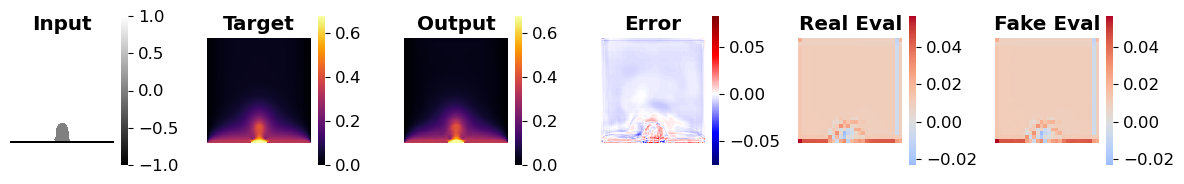

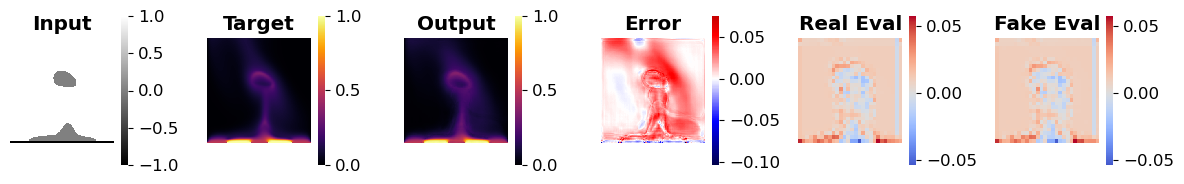

In [40]:
# %%time
# Non-first call instance error is resolved by running the entire GAN structure again
epochs = 30; steps = int(epochs*(extDataX.shape[0]-valX.shape[0])/batchSize); 
fitStep(extDataX, extDataY, 
		valX, valY, 
		steps, epochs, augTrainAll, 
  		allLossG, allLossD, allLossGV, allLossDV)

netSteps += steps

## Training & Validation Losses

In [41]:
# Resolution
DPI = 120
frameStart = 150

In [42]:
def lossDisplay(lossValues, lossLabels, ax, colorSet, subtitle, logAx=False, logRef=2, ref=1, stepOffset=0):
    
    lossValues = np.transpose(np.array(lossValues)) #reorient data
    
    totalSteps = len(lossValues[0])
    stepRange = range(stepOffset, totalSteps)
    
    for i in range(len(lossValues)):
        
        ax.plot(stepRange, lossValues[i], color=colorSet[i], label=lossLabels[i], linewidth=lineWidthDef)
        
    if logRef > 0:
        ax.axhline(y = np.log(logRef), color = 'black', linestyle = '--', label=f'$\ln${logRef} Reference')
        #ax.axhline(y = ref, color = 'black', linestyle = '--', label=f'Adversarial Equilibrium')
        
    if logAx == True:
        ax.set_yscale('log')
        
    ax.set_title(subtitle, fontweight='bold')
    ax.legend()

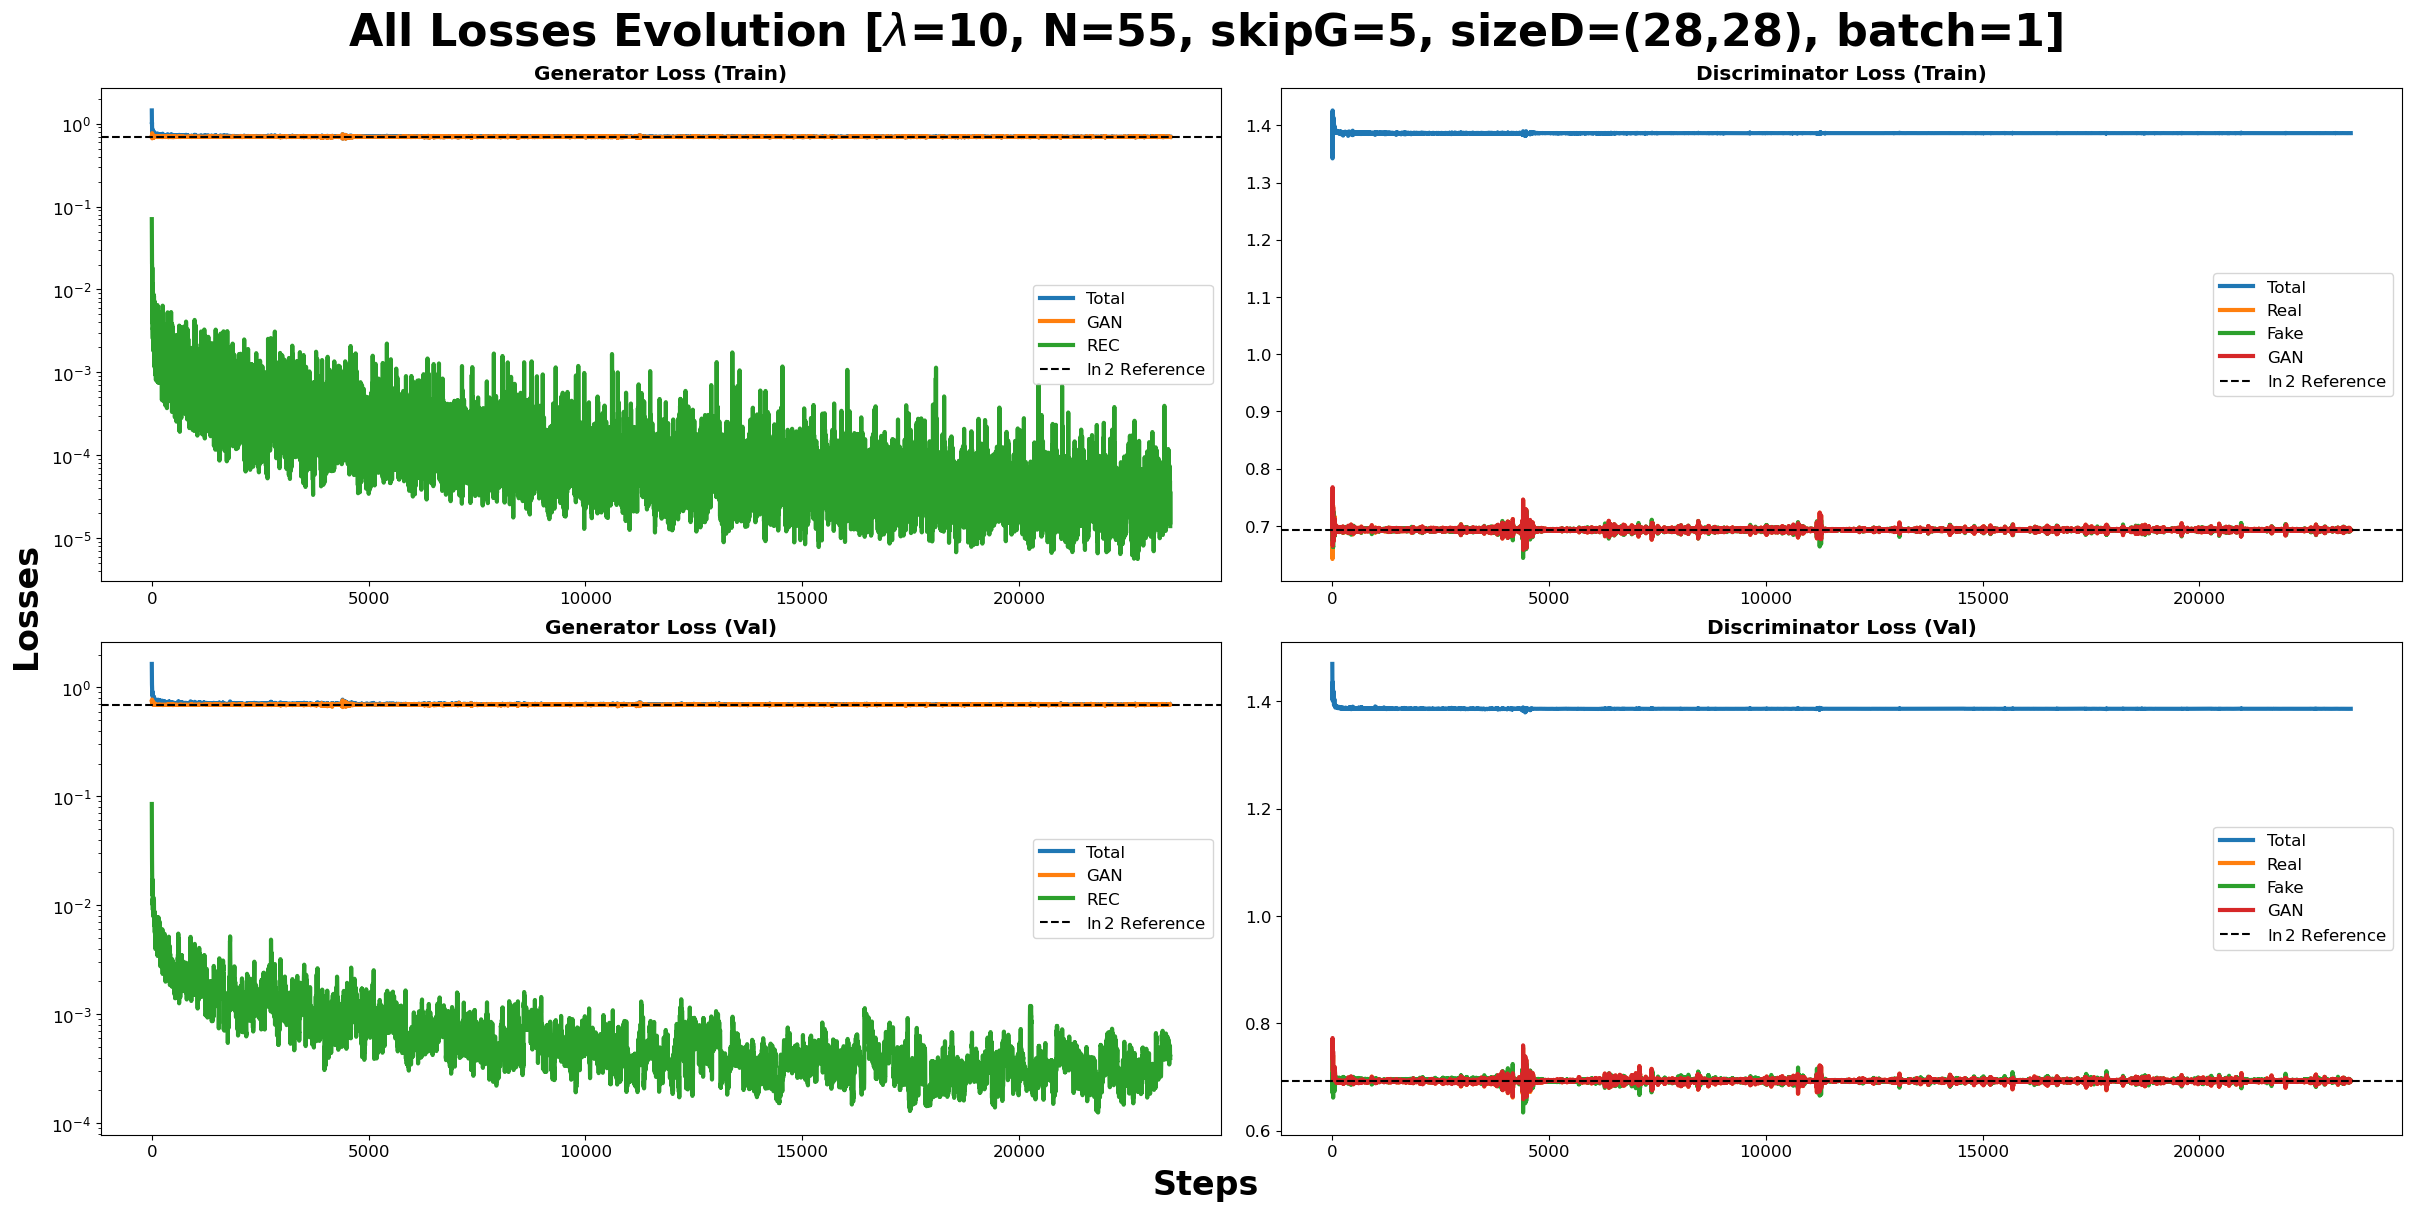

In [43]:
fig, ax = plt.subplots(2,2,figsize=(24,12), constrained_layout=True); 

lossNamesG = ['Total', 'GAN', 'REC', 'Boundary', 'Grad']
lossNamesD = ['Total', 'Real', 'Fake', 'GAN']

lossDisplay(allLossG, lossNamesG, ax[0,0], defaultColorSet1, 'Generator Loss (Train)', logAx=True)
lossDisplay(allLossD, lossNamesD, ax[0,1], defaultColorSet1, 'Discriminator Loss (Train)', logAx=False)
lossDisplay(allLossGV, lossNamesG, ax[1,0], defaultColorSet1, 'Generator Loss (Val)', logAx=True)
lossDisplay(allLossDV, lossNamesD, ax[1,1], defaultColorSet1, 'Discriminator Loss (Val)', logAx=False)

fig.supxlabel("Steps", fontweight='bold', fontsize=24) 
fig.supylabel("Losses", fontweight='bold', fontsize=24) 
fig.suptitle(f"All Losses Evolution [$\lambda$={reconSCALE}, N={patchSize}, "
             f"skipG={skipCount}, sizeD=({dShapeDim1},{dShapeDim2}), batch={batchSize}]", 
             fontweight='bold', fontsize=32, x=0.5) 

#fig.tight_layout()
#plt.show()
plt.savefig('LossTrain'+lossRatio+'.png', dpi=1000)

In [44]:
finalLossG = np.array(allLossG)[-1]
finalLossD = np.array(allLossD)[-1]
print(f"Loss G is {finalLossG} and Loss D is {finalLossD}")

Loss G is [6.93523526e-01 6.93377018e-01 1.40103439e-05] and Loss D is [1.38627076 0.69334865 0.69292212 0.69337702]


In [45]:
generator.save('G'+lossRatio)
discriminator.save('D'+lossRatio)

INFO:tensorflow:Assets written to: G_GANp3i1\assets


INFO:tensorflow:Assets written to: G_GANp3i1\assets


INFO:tensorflow:Assets written to: D_GANp3i1\assets


INFO:tensorflow:Assets written to: D_GANp3i1\assets


### Final Result On Training/Validation/Testing Set

In [46]:
def resultBatchIMG(modelG, modelD, dataset, mainTitle, 
                   sampleCount=6, layer=0,
                   invertAxes=True, hideAxes=True, 
                   tickCount=3, offset=0):
    
	subtitles = ['Input', 'Target', 'Output', 'Error', 'Real Eval', 'Fake Eval']
	cmapList = ['binary_r', 'inferno', 'inferno', 'seismic', 'coolwarm', 'coolwarm']
	centerValue = [None, None, None, 0, 0, 0]
	cbarShow = [True, False, True, True, False, True]

	baseSize = 8; figH = 2;
	fig, axes = plt.subplots(sampleCount,len(subtitles),figsize=(figH*baseSize, figH*sampleCount))
 
	fig.suptitle(mainTitle, fontsize=24, fontweight='bold', x=0.5)
 
	sampleNum = 0;
  
	for input, target in dataset.take(sampleCount):
    
		# Evaluate image
		predTensor = modelG(input, training=True)
		pred = np.array(predTensor) + offset
		error = pred[0,:,:,layer] - target[0,:,:,layer]
	
		discOutFake = modelD([input, predTensor], training=False)
		discOutReal = modelD([input, target], training=False)

		# Display range
		genMin = np.min(target[0,:,:,layer])
		genMax = np.max(target[0,:,:,layer])
		discMin = np.min(np.minimum(discOutFake[0,:,:,0], discOutReal[0,:,:,0]))
		discMax = np.max(np.maximum(discOutFake[0,:,:,0], discOutReal[0,:,:,0]))

		cbarMin = [None, genMin, genMin, None, discMin, discMin]
		cbarMax = [None, genMax, genMax, None, discMax, discMax]
	
		figures = [input[0,:,:,layer], target[0,:,:,layer], pred[0,:,:,layer], error, 
             		discOutReal[0,:,:,0], discOutFake[0,:,:,0]]

		for i in range(len(figures)):
			
			#plt.subplot(1, len(figures), i+1)
			
			# Plot already normalized.
			sns.heatmap(figures[i], cmap=cmapList[i], cbar=cbarShow[i],
						center=centerValue[i], vmin=cbarMin[i], vmax=cbarMax[i],
						square=True, ax=axes[sampleNum][i],
						xticklabels=int(figures[i].shape[1]/tickCount), yticklabels=int(figures[i].shape[0]/tickCount))
			
			if sampleNum == 0:
				axes[sampleNum][i].set_title(subtitles[i], fontweight='bold', fontsize=16)
	
			if invertAxes == True:
				axes[sampleNum][i].invert_yaxis()
				
			if hideAxes == True:          
				axes[sampleNum][i].axis('off')
    
		sampleNum += 1

	fig.tight_layout()
	plt.show()

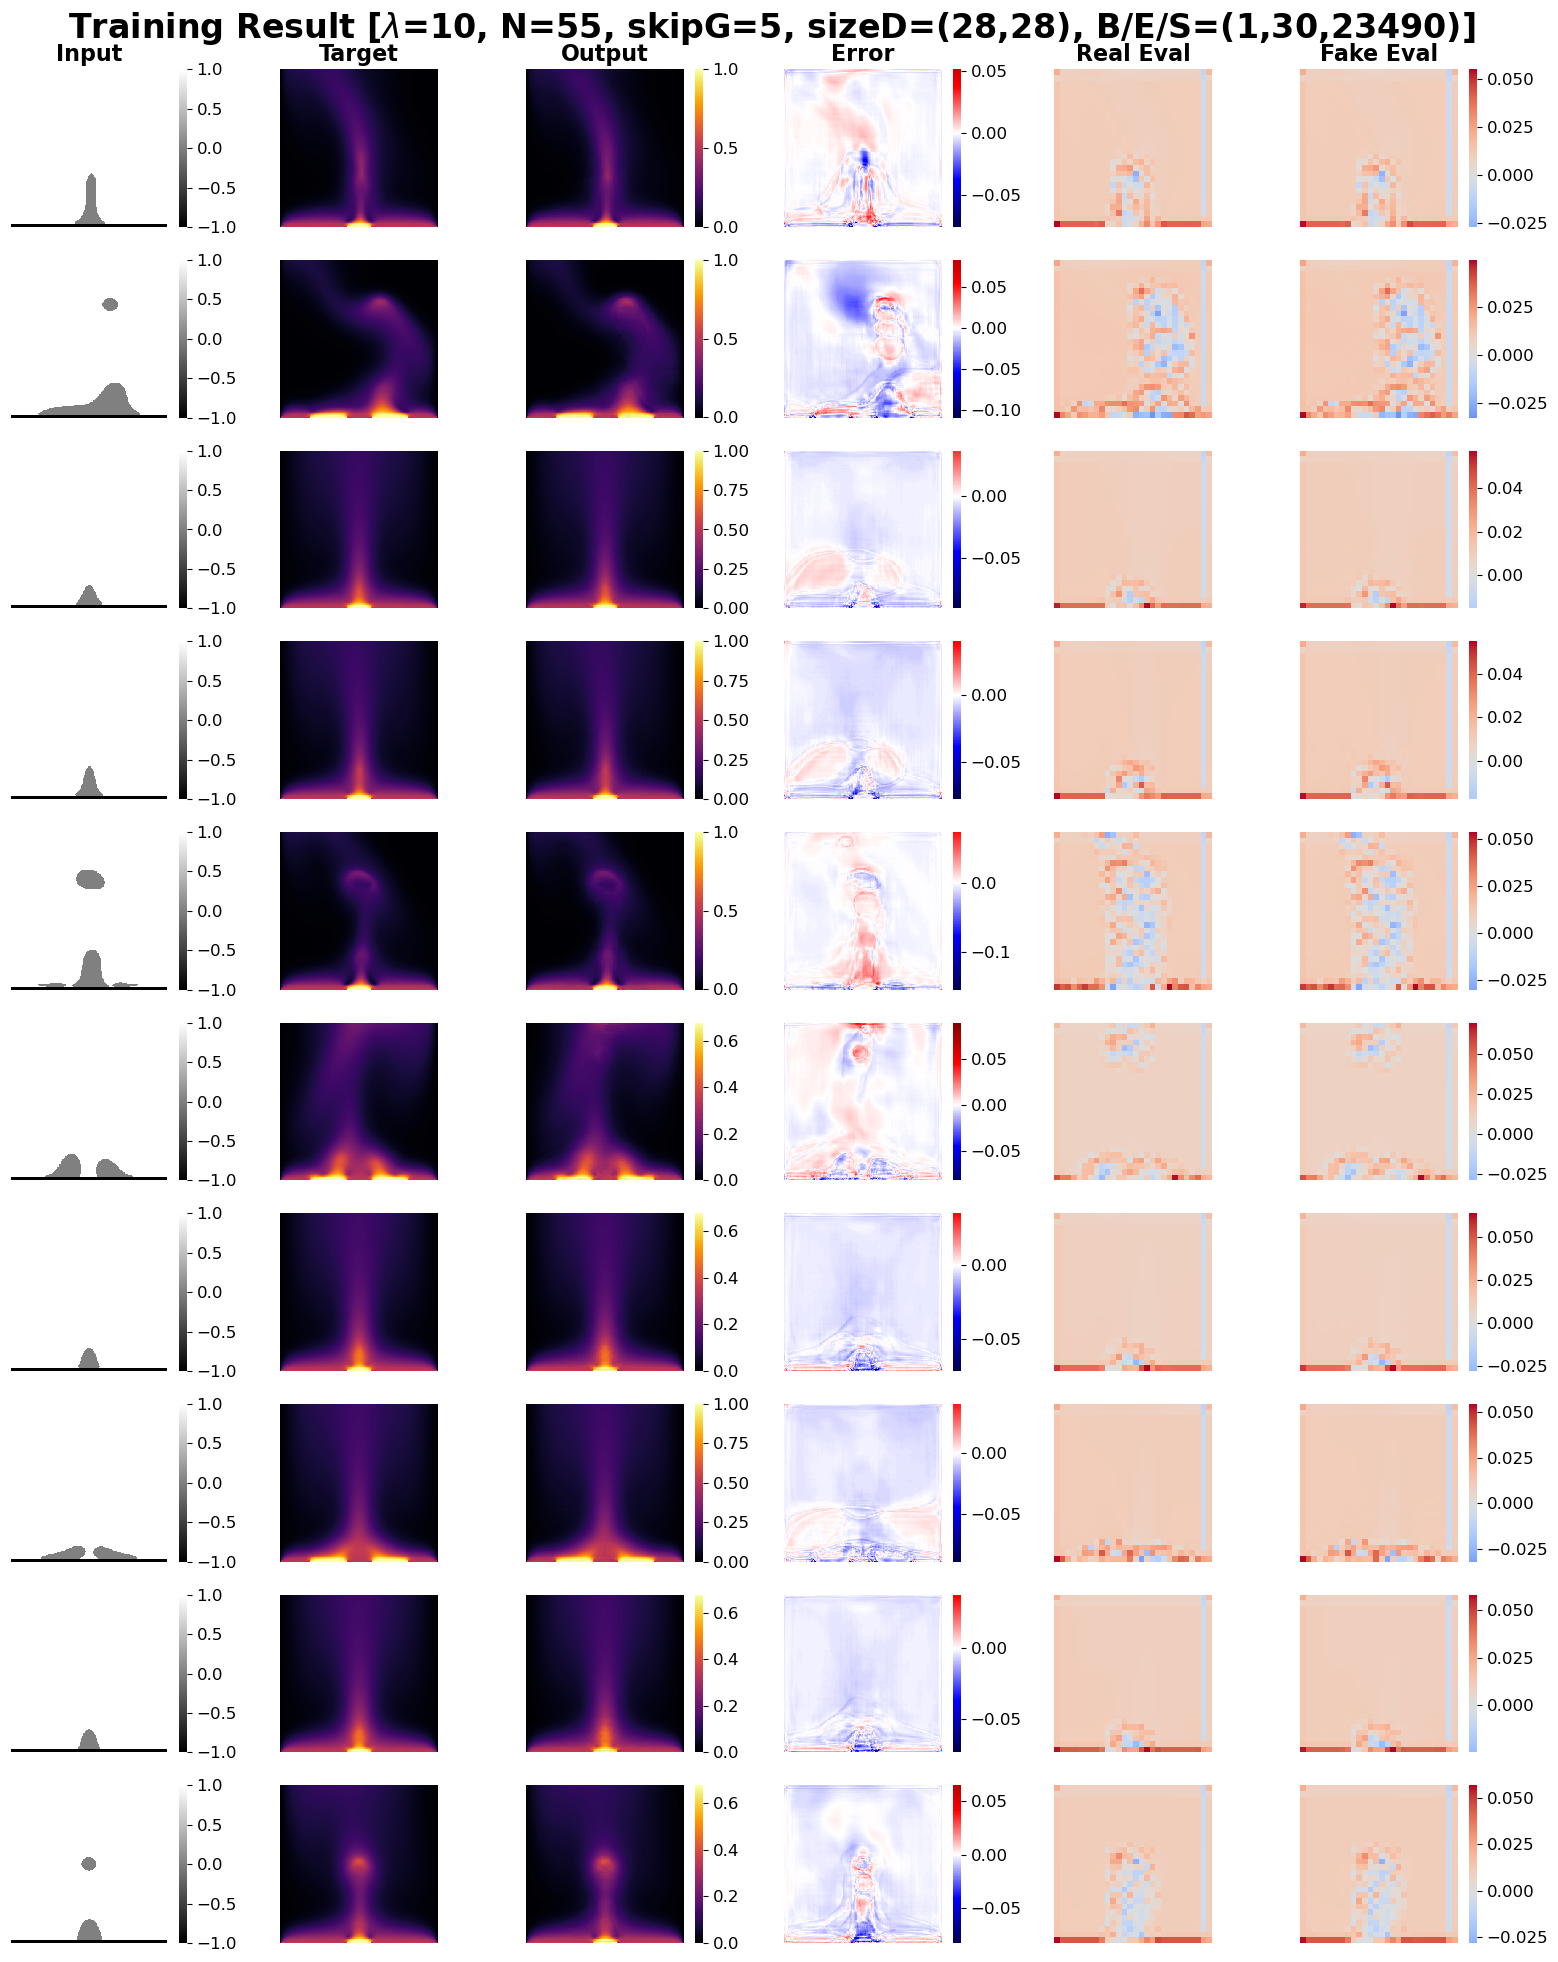

In [47]:
trainTitle = (f"Training Result [$\lambda$={reconSCALE}, N={patchSize}, "
				f"skipG={skipCount}, sizeD=({dShapeDim1},{dShapeDim2}), "
				f"B/E/S=({batchSize},{epochs},{netSteps})]")
resultBatchIMG(generator, discriminator, augTrainAll, trainTitle, sampleCount=10, layer=0)

### Temporal Error

In [48]:
def resultBatchIMGT(modelG, dataset, mainTitle, 
                   sampleCount=6, layer=0,
                   invertAxes=True, hideAxes=True, 
                   tickCount=3, offset=0):
    
	subtitles = ['Input', 'Target', 'Output', 'Error']
	cmapList = ['binary_r', 'coolwarm', 'coolwarm', 'seismic']
	centerValue = [None, None, None, 0]
	cbarShow = [True, False, True, True]

	baseSize = 5; figH = 2;
	fig, axes = plt.subplots(sampleCount,len(subtitles),figsize=(figH*baseSize, figH*sampleCount))
 
	fig.suptitle(mainTitle, fontsize=24, fontweight='bold', x=0.5)
 
	sampleNum = 0;
  
	for input, target in dataset.take(sampleCount):
    
		# Evaluate image
		predTensor = modelG(input, training=True)
		pred = np.array(predTensor) + offset
		predT = pred[0,:,:,layer] - pred[0,:,:,layer+1]
		targetT = target[0,:,:,layer] - target[0,:,:,layer+1]
		error = predT - targetT

		# Display range
		genMin = np.min(targetT)
		genMax = np.max(targetT)

		cbarMin = [None, genMin, genMin, None]
		cbarMax = [None, genMax, genMax, None]
	
		figures = [input[0,:,:,layer], targetT, predT, error]

		for i in range(len(figures)):
			
			#plt.subplot(1, len(figures), i+1)
			
			# Plot already normalized.
			sns.heatmap(figures[i], cmap=cmapList[i], cbar=cbarShow[i],
						center=centerValue[i], vmin=cbarMin[i], vmax=cbarMax[i],
						square=True, ax=axes[sampleNum][i],
						xticklabels=int(figures[i].shape[1]/tickCount), yticklabels=int(figures[i].shape[0]/tickCount))
			
			if sampleNum == 0:
				axes[sampleNum][i].set_title(subtitles[i], fontweight='bold', fontsize=16)
	
			if invertAxes == True:
				axes[sampleNum][i].invert_yaxis()
				
			if hideAxes == True:          
				axes[sampleNum][i].axis('off')
    
		sampleNum += 1

	fig.tight_layout()
	#plt.show()

IndexError: index 1 is out of bounds for axis 3 with size 1

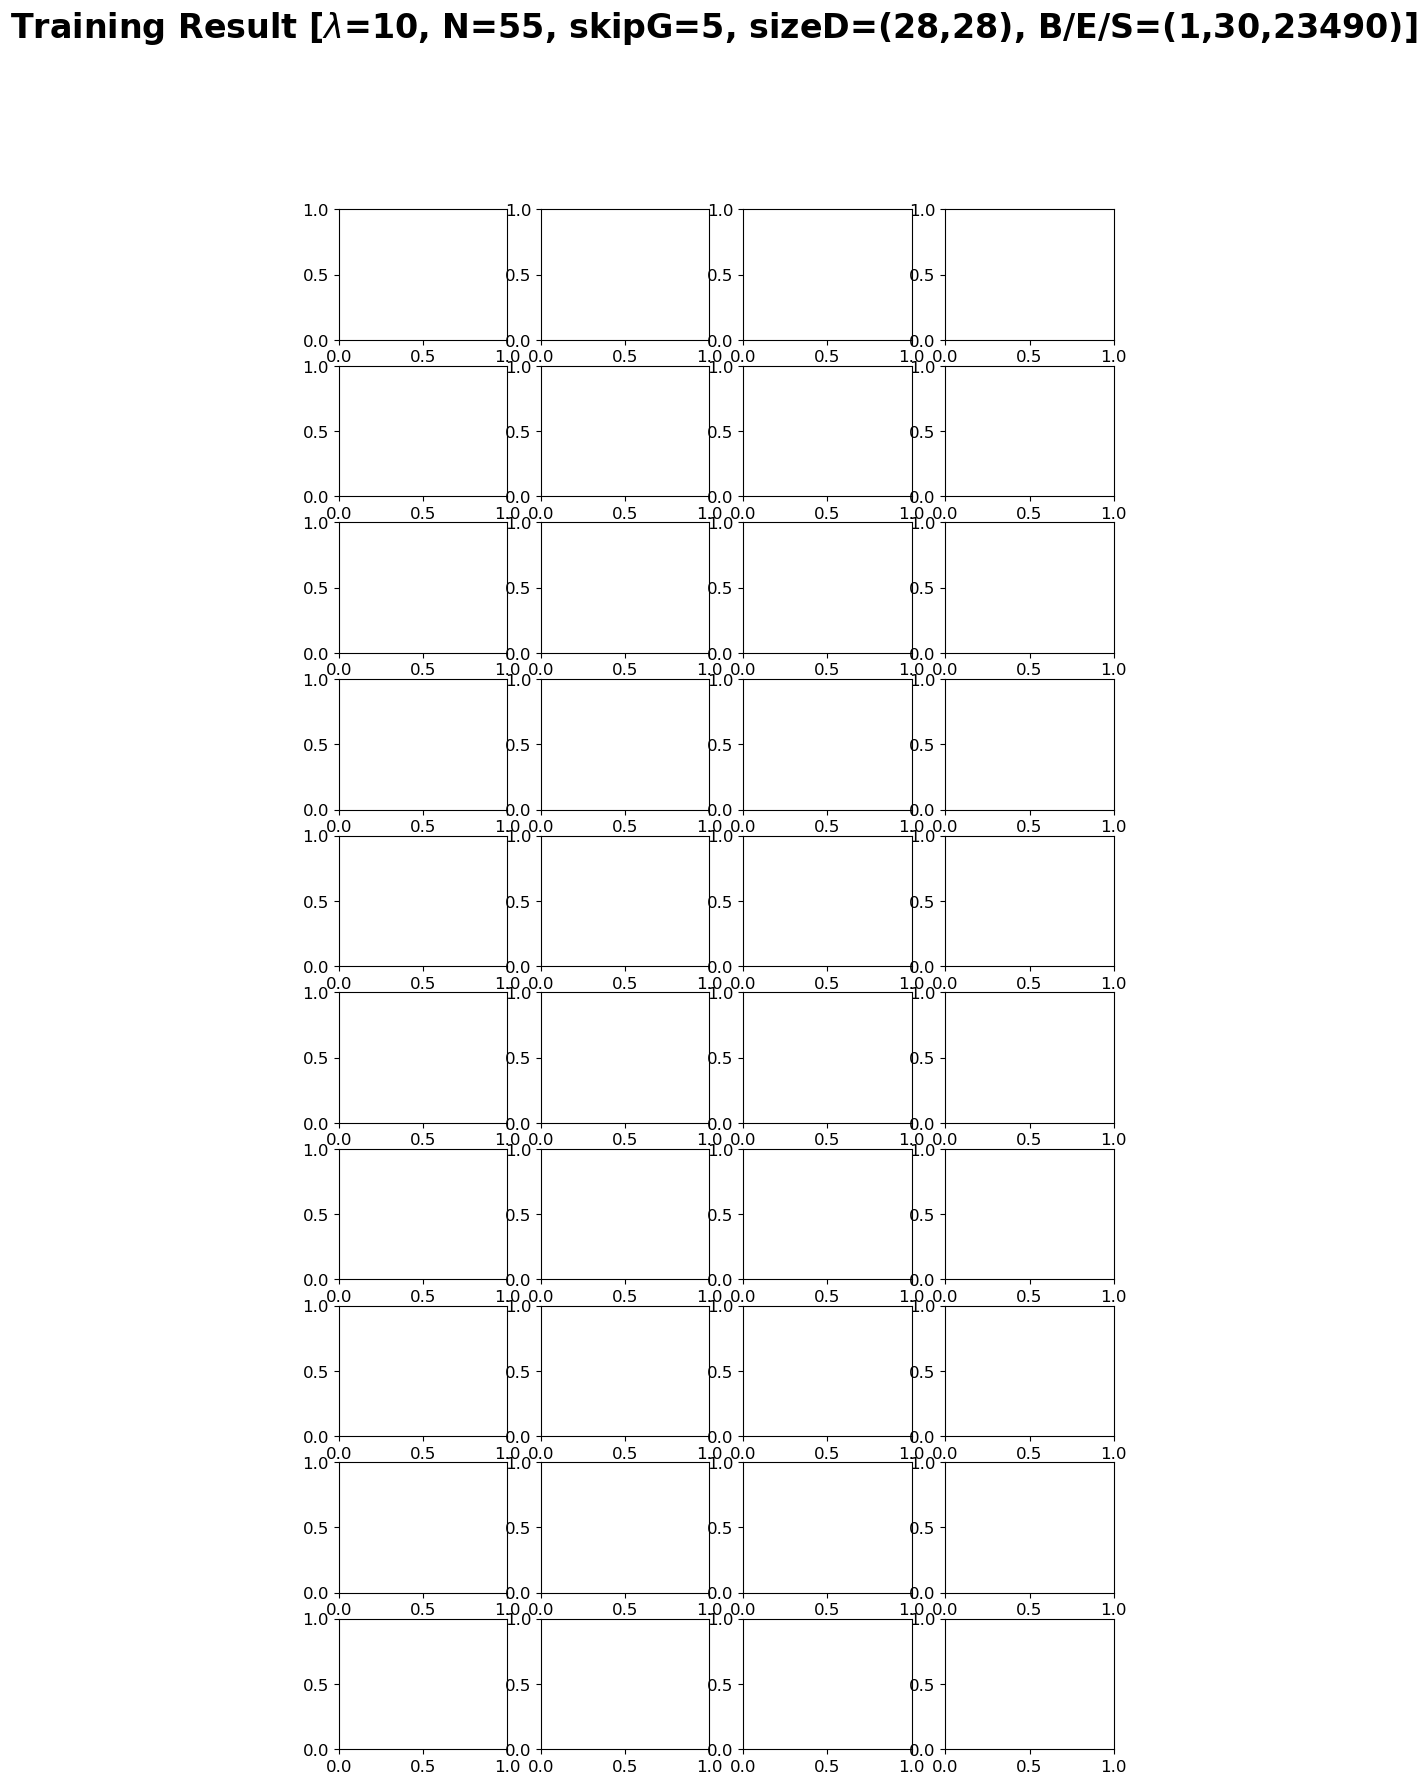

In [49]:
resultBatchIMGT(generator, augTrainAll, trainTitle, sampleCount=10)
plt.savefig('TempTrain'+lossRatio, dpi=DPI)

### Error Statistics

In [ ]:
def heatFluxCompute(density, temp, flux=True):
    
    # Density = 1, 1*1.044/1.679/1000
    # Conductivity = 680e-3, 24.8e-3
	kappa = density[solidH+1,:]
	kappa = np.where(kappa>0.5, 528/1000, 76.7/1000)
    
	tempDiff = temp[solidH,:] - temp[solidH-1,:]
	#ambDiff = temp[expH:] - expSatT
	qPP = kappa * tempDiff
 
	if flux == True:
		qPP = qPP / (2.762/23/10)

	#Nu = -tempDiff / ambDiff * 23.00421
  
	return -qPP

In [ ]:
def errorStatistics(modelG, datasetX, datasetY, tickCount=3, invertAxes=True, hideAxes=True):
    
	subtitles = ['Layer 1 Error%', 'Layer 2 Error%', 'Layer 1 Max Error%', 'Layer 2 Max Error%']
	cmapList = 'cividis'
	cbarShow = [True, True, False, True]
 
	fig, axes = plt.subplots(1,3,figsize=(16,4))
	#rowPlot(data, subtitles, cmapList, centerValue, sampleIndex=-1, h=4, xspace=32, yspace=64)

	layer = 1; qMin = 0; qMax = 150
	error = np.zeros([256, 256, layer]); 
	errorMaximum = np.zeros([256, 256, layer]);
	qPPTrueAll = []; qPPPredAll = []
	for t in range(len(datasetX)):

		# Evaluate image
		predTensor = modelG(datasetX[t,...][tf.newaxis,...], training=True)
		pred = np.array(predTensor)
		pred = revertT(pred, scaleTrain)
  
		for l in range(layer):
			currentError = np.abs(pred[0,:,:,l] - datasetY[t,...,l]) / datasetY[t,...,l] * 100
			errorMaximum[...,l] = np.maximum(currentError, errorMaximum[...,l])
			error[...,l] += currentError
   
		qPPTrue = heatFluxCompute(datasetX[t,...,0], datasetY[t,...,0])
		qPPPred = heatFluxCompute(datasetX[t,...,0], pred[0,...,0])
		#axes[-1].plot(range(qPPPred.shape[-1]), qPPPred, linewidth=1, color=defaultColorSet1[1], alpha=0.2)	
		#axes[-1].plot(range(qPPTrue.shape[-1]), qPPTrue, linewidth=1, color=defaultColorSet1[2], alpha=0.2)
		#axes[-1].axhline(y=30, color='k', linestyle='--')
		qPPTrueAll.append(np.mean(qPPTrue));
		qPPPredAll.append(np.mean(qPPPred))
  
	trueMin = np.min(qPPTrueAll); trueMean = np.mean(qPPTrueAll); trueMax = np.max(qPPTrueAll)
	predMin = np.min(qPPPredAll); predMean = np.mean(qPPPredAll); predMax = np.max(qPPPredAll)
	axes[-1].axhline(y=trueMean, color='k', linewidth=3, linestyle='-')
	axes[-1].axhline(y=predMean, color='tab:blue', linewidth=3, linestyle='-')
	axes[-1].fill_between(np.linspace(0,256,512), trueMin, trueMax, color='k', alpha=0.2)
	axes[-1].fill_between(np.linspace(0,256,512), predMin, predMax, color='tab:blue', alpha=0.2)
  
	axes[-1].set_xlim([0,255]); axes[-1].set_ylim([qMin, qMax])
	axes[-1].set_xticks([]); axes[-1].set_yticks([])
	axes[-1].set_aspect(255/(qMax-qMin))
	axes[-1].set_title(f'Pred:{predMin:.1f}, {predMean:.1f}, {predMax:.1f}\nTrue:{trueMin:.1f}, {trueMean:.1f}, {trueMax:.1f}')

	error /= datasetX.shape[0]

	# Display range
	errorMin = 0
	errorMax = 5;

	barRange = [2, errorMax]

	figures = [error[...,0], errorMaximum[...,0]]

	for i in range(len(figures)):
		
		# Plot already normalized.
		sns.heatmap(figures[i], cmap=cmapList, cbar=cbarShow[i],
					vmin=errorMin, vmax=barRange[i],
					square=True, ax=axes[i], cbar_kws=dict(ticks=np.linspace(0,barRange[i],5)))
  
		#axes[i].set_title(subtitles[i], fontweight='bold', fontsize=16)

		if invertAxes == True:
			axes[i].invert_yaxis()
			
		if hideAxes == True:          
			axes[i].axis('off')

	fig.tight_layout()

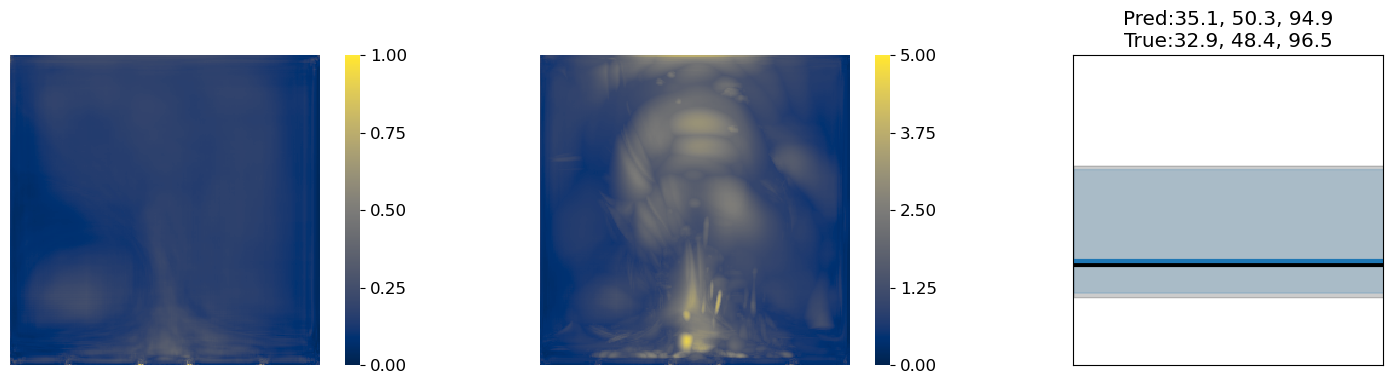

In [ ]:
errorStatistics(generator, extDataX, revertT(extDataY,scaleTrain))
plt.savefig('ErrorTrain'+lossRatio, dpi=DPI)
#plt.show()

IndexError: index 3 is out of bounds for axis 0 with size 3

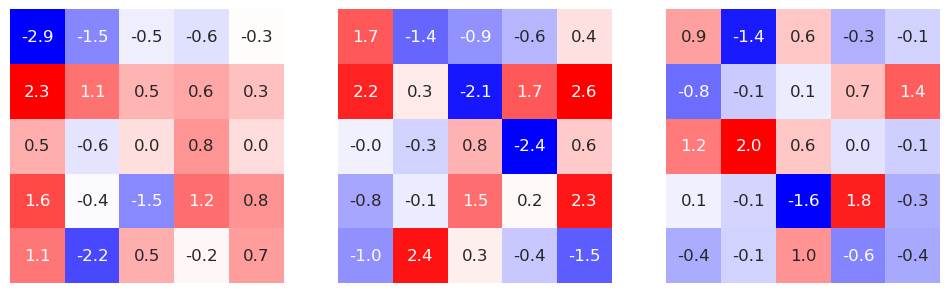

In [ ]:
#%%script skip
w = discriminator.layers[3].get_weights()[0][...,0]

def weightVisualizer(w):
    
	fig, ax = plt.subplots(1,3,figsize=(12,6))

	for i in range(w.shape[-1]):
		sns.heatmap(w[...,i], cbar=False, cmap='bwr', ax=ax[i],
					square=True, annot=True, fmt='.1f',
					xticklabels=False, yticklabels=False)
	plt.show()
 
weightVisualizer(w*100)

## Output Videos

In [ ]:
extDataY0 = revertT(extDataY, scaleTrain)
#minT = np.min(extDataY0); maxT = np.max(extDataY0)
minT = 300; maxT = 425

c:\Users\19055\anaconda3\envs\tf210\lib\site-packages\matplotlib\animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


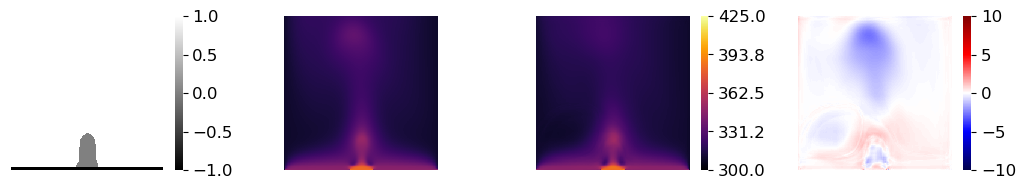

In [ ]:
baseSize = 6.5; figH = 2;
fig, axes = plt.subplots(1,4,figsize=(figH*baseSize, figH))
 
def resultFrame(modelG, input, target, layer=0, tickCount=3, hideAxes=True, show=False):
    
	subtitles = ['Input', 'Target', 'Output', 'Error%']
	cmapList = ['binary_r', 'inferno', 'inferno', 'seismic']
	centerValue = [None, None, None, 0]
	cbarMin = [-1, minT, minT, -10]
	cbarMax = [1, maxT, maxT, 10]

	if show == True:
		cbarShow = [True, False, True, True]
		# for i in range(len(subtitles)):
		# 	axes[i].set_title(subtitles[i], fontweight='bold')
   
	else:
		cbarShow = [False, False, False, False]
 
    # Evaluate each frame
	predTensor = modelG(input[tf.newaxis, ...], training=True)
	pred = np.array(predTensor)[0]
	pred = revertT(pred[:,:,layer], scaleTrain) - 273.15
	target = target - 273.15
	error = (pred - target[...,layer]) / target[...,layer] * 100

	figures = [input[...,layer], target[...,layer], pred, error]

	for i in range(len(figures)):
		
		# Plot already normalized.
		sns.heatmap(figures[i], cmap=cmapList[i], cbar=cbarShow[i],
					center=centerValue[i], vmin=cbarMin[i], vmax=cbarMax[i],
					square=True, ax=axes[i], cbar_kws=dict(ticks=np.linspace(cbarMin[i],cbarMax[i],5)),
					xticklabels=int(figures[i].shape[1]/tickCount), 
     				yticklabels=int(figures[i].shape[0]/tickCount))
  
		axes[i].invert_yaxis()
			
		if hideAxes == True:          
			axes[i].axis('off')

def plotDraw(frame=frameStart, show=False):
	resultFrame(generator, extDataX[frame,...], extDataY0[frame,...], show=show)

def animate(j):
    offset = 1+frameStart
    plotDraw(frame=j+offset)

#fmt: g = int, .2f = float
plotDraw(show=True)
	
#fig.tight_layout()
ani = anim.FuncAnimation(fig=fig, func=animate, frames=40, interval=200)
plt.show()

In [ ]:
dataName = "trainBest"+lossRatio
ani.save(f"{dataName}.mp4", writer='ffmpeg')

# **Interpolation Test (Temperature)**

In [ ]:
def dataLoaderTest(types, scaleTrain, *path):

	dataSimTest, dataIndexTest = simDataExtract(types, *path)
	print(dataIndexTest)

	dataSimX = dataSimTest[types[0]]
	dataSimY = dataSimTest[types[1]]
 
	dataSimX = phaseQ(dataSimX)
	dataSimY = Jakob(dataSimY)
	#dataSimY = (dataSimY - scaleTrain[0])/scaleTrain[1]
	dataSimY = dataSimY / scaleTrain[0]

	#extDataX, extDataY = channelExtend2D(dataSimX, dataSimY, prev=0)
	extDataX, extDataY = channelExtendWithInitial(dataSimX, dataSimY, dataIndexTest, prev=bundle) 

	channelX = extDataX.shape[-1]; channelY = extDataY.shape[-1]
	print(f"Number of input channels: {channelX}.\nInput Dimension: {extDataX.shape}")
	print(f"Number of output channels: {channelY}.\nOutput Dimension: {extDataY.shape}")
 
	extDataY = revertT(extDataY, scaleTrain)
 
	return extDataX, extDataY

In [ ]:
dataXTest, dataYTest = dataLoaderTest(["density","temperature"], scaleTrain, 
                                      "/Data Folder/dataSim0/c5/data",
                                      "/Data Folder/dataSim0/c2/data")

[0, 200, 400]
Number of input channels: 4.
Input Dimension: (394, 256, 256, 4)
Number of output channels: 1.
Output Dimension: (394, 256, 256, 1)


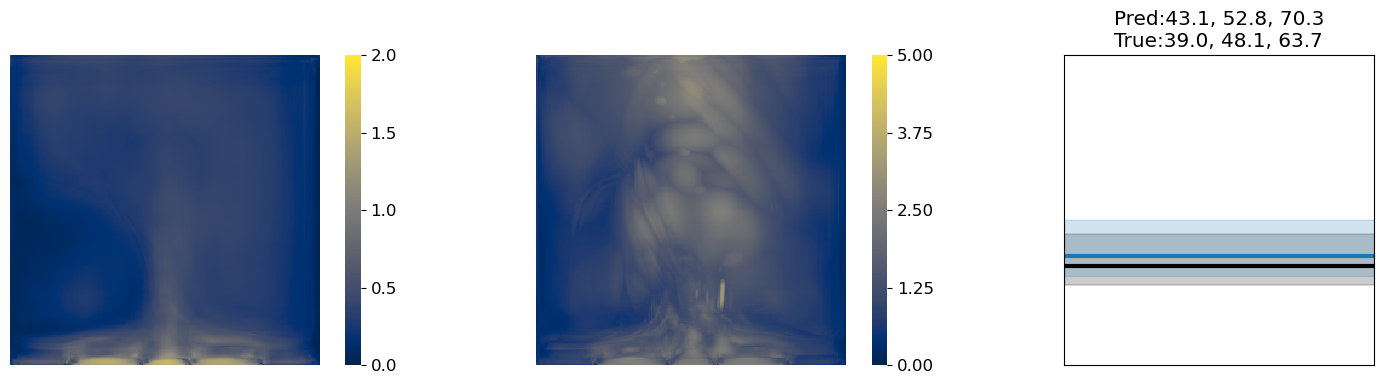

In [ ]:
errorStatistics(generator, dataXTest, dataYTest)
plt.savefig('ErrorTestT'+lossRatio, dpi=DPI)

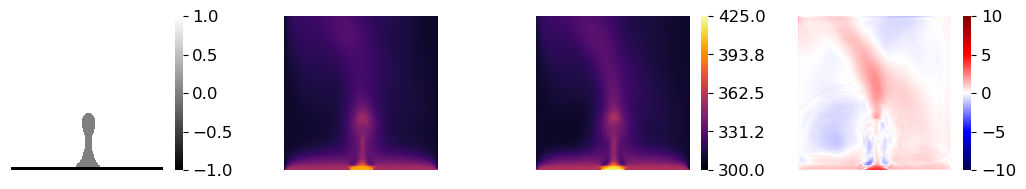

In [ ]:
baseSize = 6.5; figH = 2;
fig, axes = plt.subplots(1,4,figsize=(figH*baseSize, figH))

#minT = np.min(dataYTest); maxT = np.max(dataYTest)

def plotDraw(frame=frameStart, show=False):
	resultFrame(generator, dataXTest[frame,...], dataYTest[frame,...], show=show)

def animate(j):
    offset = frameStart
    plotDraw(frame=j+offset)

#fmt: g = int, .2f = float
plotDraw(show=True)
	
#fig.tight_layout()
ani = anim.FuncAnimation(fig=fig, func=animate, frames=30, interval=200)
plt.show()

In [ ]:
dataName = "ITT1"+lossRatio
ani.save(f"{dataName}.mp4", writer='ffmpeg')

# **Interpolation Testing (Heater Arrangement)**

In [ ]:
#(1,3),(7,9)
dataXTest, dataYTest = dataLoaderTest(["density","temperature"], scaleTrain, 
                                      "/Data Folder/dataSim0/c7/data",
                                      "/Data Folder/dataSim0/c9/data")

[0, 200, 400]
Number of input channels: 4.
Input Dimension: (394, 256, 256, 4)
Number of output channels: 1.
Output Dimension: (394, 256, 256, 1)


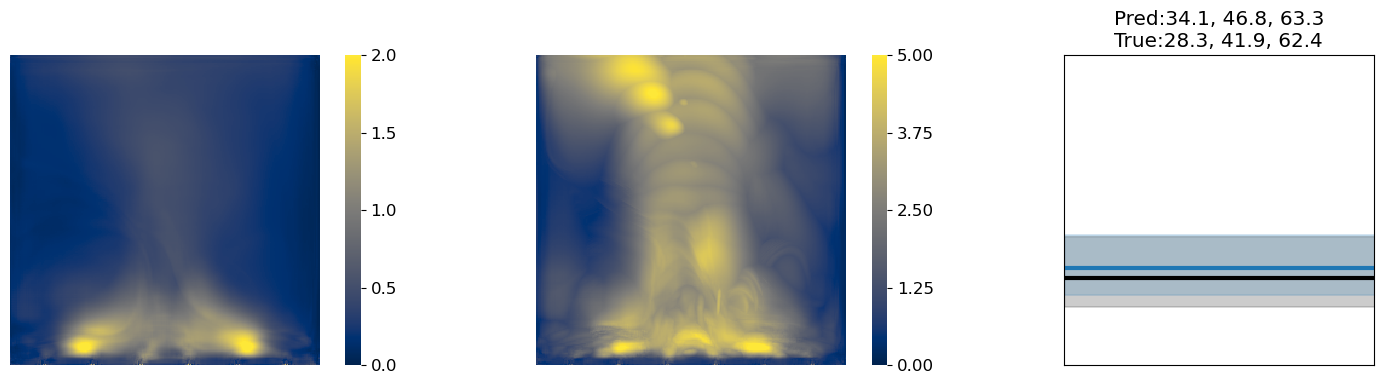

In [ ]:
errorStatistics(generator, dataXTest, dataYTest)
plt.savefig('ErrorTestHA'+lossRatio, dpi=DPI)

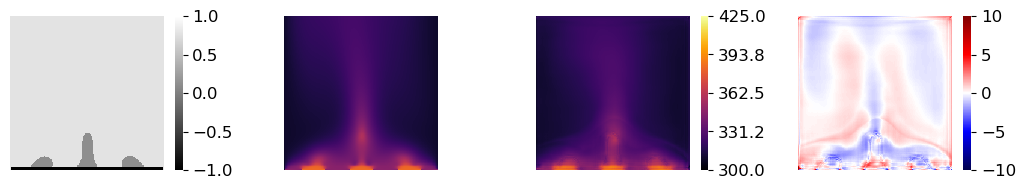

In [ ]:
baseSize = 6.5; figH = 2;
fig, axes = plt.subplots(1,4,figsize=(figH*baseSize, figH))

#minT = np.min(dataYTest); maxT = np.max(dataYTest)

def plotDraw(frame=frameStart, show=False):
	resultFrame(generator, dataXTest[frame,...], dataYTest[frame,...], show=show)

def animate(j):
    offset = frameStart
    plotDraw(frame=j+offset)

#fmt: g = int, .2f = float
plotDraw(show=True)
	
#fig.tight_layout()
ani = anim.FuncAnimation(fig=fig, func=animate, frames=45, interval=200)
plt.show()

In [ ]:
dataName = "ITHA1"+lossRatio
ani.save(f"{dataName}.mp4", writer='ffmpeg')

# **Interpolation Testing (Both)**

In [ ]:
dataXTest, dataYTest = dataLoaderTest(["density","temperature"], scaleTrain, 
                                      "/Data Folder/dataSim0/c8/data")

[0, 200]
Number of input channels: 4.
Input Dimension: (197, 256, 256, 4)
Number of output channels: 1.
Output Dimension: (197, 256, 256, 1)


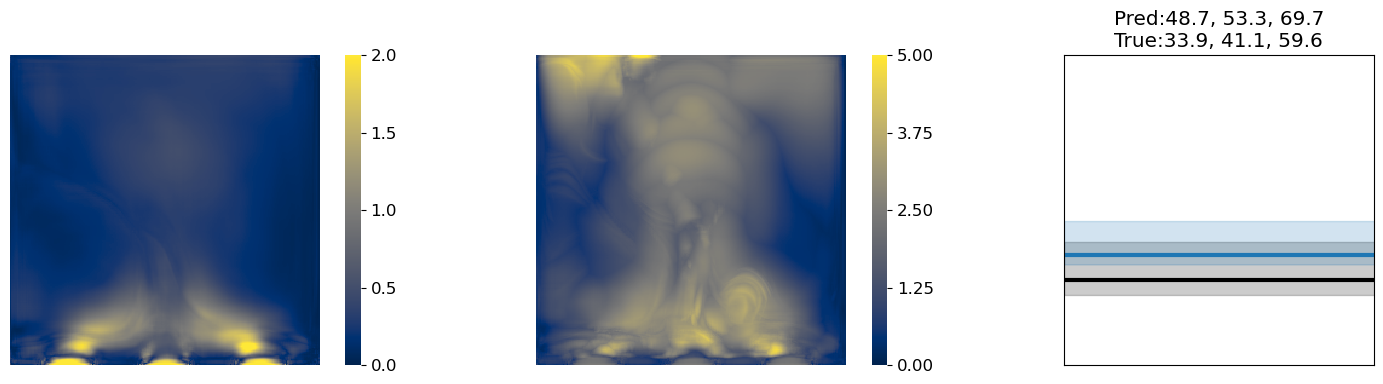

In [ ]:
errorStatistics(generator, dataXTest, dataYTest)
plt.savefig('ErrorTestB'+lossRatio, dpi=DPI)

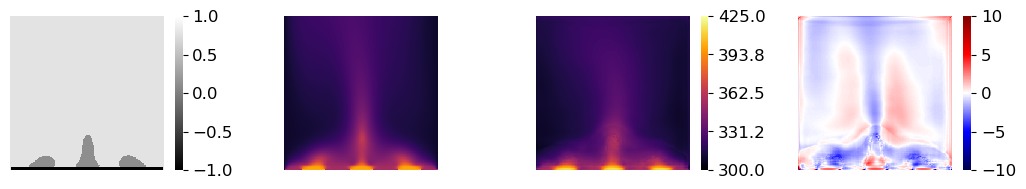

In [ ]:
baseSize = 6.5; figH = 2;
fig, axes = plt.subplots(1,4,figsize=(figH*baseSize, figH))

#minT = np.min(dataYTest); maxT = np.max(dataYTest)

def plotDraw(frame=frameStart, show=False):
	resultFrame(generator, dataXTest[frame,...], dataYTest[frame,...], show=show)

def animate(j):
    offset = frameStart
    plotDraw(frame=j+offset)

#fmt: g = int, .2f = float
plotDraw(show=True)
	
#fig.tight_layout()
ani = anim.FuncAnimation(fig=fig, func=animate, frames=40, interval=200)
plt.show()

In [ ]:
dataName = "ITB1"+lossRatio
ani.save(f"{dataName}.mp4", writer='ffmpeg')